# **Analyse in Pandas en PowerBI**
Groep 8

***Airport iata codes*** <br>
**FR** = Ryanair <br>
**SN** = Brussels Airlines <br>
**HV** = Transavia <br>
**TB** = Tui

In [1]:
import os
import csv
import sys
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as sql
from dotenv import load_dotenv

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

dotenv_path = "../.env"
load_dotenv(dotenv_path)

True

## Data

### Datawarehouse MySQL Workbench

In [2]:
# make a connection to the database
dwh = sql.connect(
    host="127.0.0.1",   # ip-adres
    port=3306,   # poortnummer
    user=os.getenv("USER"),   # username
    password=os.getenv("PASSWORD"),   # wachtwoord
    database="AirFaresDWH"   # naam van de datawarehouse in mysql workbench
    # database="groep8dep"   # naam van de OLTP database in mysql workbench
)

# check if the connection succeeded
print(dwh)

In [14]:
# create cursor
cursor = dwh.cursor()

# use the right database
cursor.execute("USE AirFaresDWH")

# create query
query = """
SELECT
  dep_airport.airport_key, dep_airport.airport_iata_code, dep_airport.airport_name, dep_airport.location, dep_airport.country,
  airline.airline_key, airline.airline_iata_code, airline.airline_name, airline.country,
  flight.flight_key, flight.flight_id, flight.flightnumber, flight.numberOfStops, flight.departureTime, flight.arrivalTime, flight.duration, flight.start_date, flight.end_date,
  dep_date.date_key, dep_date.date, dep_date.day_of_week, dep_date.day_of_month, dep_date.day_of_year, dep_date.year, dep_date.dayName, dep_date.monthName, dep_date.nameOfQuarter, dep_date.numberOfQuarter, dep_date.isWeekend, dep_date.isWeekDay, dep_date.isHoliday,
  fact.flightfare_key, fact.flight_key, fact.airline_key, fact.depatureAirportKey, fact.arrivalAirportKey, fact.scrapeDateKey, fact.departureDateKey, fact.arrivalDateKey, fact.availableSeats, fact.price
FROM factflightfare AS fact
JOIN dimairline AS airline ON fact.airline_key = airline.airline_key
JOIN dimairport AS dep_airport ON fact.depatureAirportKey = dep_airport.airport_key
JOIN dimairport AS arr_airport ON fact.arrivalAirportKey = arr_airport.airport_key
JOIN dimflight AS flight ON fact.flight_key = flight.flight_key
JOIN dimdate AS dep_date ON fact.departureDateKey = dep_date.date_key
JOIN dimdate AS arr_date ON fact.arrivalDateKey = arr_date.date_key
JOIN dimdate AS scrape_date ON fact.scrapeDateKey = scrape_date.date_key
"""

# create the dataframe while reading query
df = pd.read_sql(query, dwh)

# show the df
df

,airport_key,airport_iata_code,airport_name,location,country,airline_key,airline_iata_code,airline_name,country,flight_key,...,flightfare_key,flight_key,airline_key,depatureAirportKey,arrivalAirportKey,scrapeDateKey,departureDateKey,arrivalDateKey,availableSeats,price
0,7,CRL,Aereport De Chaleroi Bruxelles Sud,Charleroi,Belgium,1,FR,Ryanair,Ireland,641,...,1,641,1,7,4,20230420,20230522,20230522,-1,21.99
1,5,BRU,Brussels Airline,Zaventem,Belgium,1,FR,Ryanair,Ireland,13,...,2,13,1,5,1,20230420,20230521,20230521,3,90.73
2,7,CRL,Aereport De Chaleroi Bruxelles Sud,Charleroi,Belgium,1,FR,Ryanair,Ireland,171,...,3,171,1,7,1,20230420,20230521,20230521,2,83.79
3,7,CRL,Aereport De Chaleroi Bruxelles Sud,Charleroi,Belgium,1,FR,Ryanair,Ireland,1114,...,4,1114,1,7,10,20230420,20230521,20230521,-1,93.36
4,7,CRL,Aereport De Chaleroi Bruxelles Sud,Charleroi,Belgium,1,FR,Ryanair,Ireland,375,...,5,375,1,7,2,20230420,20230521,20230521,4,132.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252716,13,OST,Oostende-Brugge International Airport,Ostend,Belgium,4,TB,Tui,Belgium,13690,...,259268,13690,4,13,17,20230426,20230712,20230712,-1,309.99
252717,13,OST,Oostende-Brugge International Airport,Ostend,Belgium,4,TB,Tui,Belgium,13690,...,259269,13690,4,13,17,20230430,20230712,20230712,-1,319.99
252718,13,OST,Oostende-Brugge International Airport,Ostend,Belgium,4,TB,Tui,Belgium,13690,...,259270,13690,4,13,17,20230423,20230712,20230712,-1,309.99
252719,13,OST,Oostende-Brugge International Airport,Ostend,Belgium,4,TB,Tui,Belgium,13690,...,259271,13690,4,13,17,20230418,20230712,20230712,-1,309.99


## Questions

### 1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

Kan zowel in Python als in PowerBI

De goedkoopste vliegtuigmaatschappij is FR met een gemiddelde prijs van 114.36 euro.
De duurste vliegtuigmaatschappij is TB met een gemiddelde prijs van 201.22 euro.


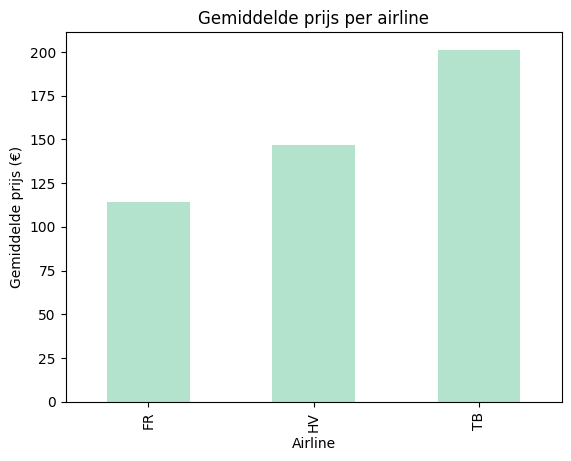

In [16]:
# read the data
data = df

# group the data by airline and calculate the average price
grouped_data = data.groupby(['airline_iata_code'])['price'].mean()
sorted_data = grouped_data.sort_values()

# print the results
print("De goedkoopste vliegtuigmaatschappij is " + sorted_data.index[0] + " met een gemiddelde prijs van", round(sorted_data[0], 2), "euro.")
print("De duurste vliegtuigmaatschappij is " + sorted_data.index[-1] + " met een gemiddelde prijs van", round(sorted_data[-1], 2), "euro.")

# plot the results
grouped_data.plot(kind='bar', colormap='Pastel2')
plt.title('Gemiddelde prijs per airline')
plt.xlabel('Airline')
plt.ylabel('Gemiddelde prijs (€)')
plt.show()

### 2) Hoe vaak vliegt elke vliegtuigmaatschappij per week naar elk van de bestemmingen?

Kan zowel in Python als in PowerBI

#### CSV voor de vluchten per bestemming per week

In [17]:
# read the data
data = df

# open new csv file
with open('../analyse/vluchtenPerWeek.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['airline_iata_code', 'arrival_airport_iata_code', 'weekNr', 'countOfFlights'])

# iterate over the data and add to array
dataArr = []
for i in range(len(data)):
    dataArr.append(data.iloc[i])

# initialize dictionary to store flights per airline per destination per week
flights_per_week = {}

# loop through the rows
for row in dataArr:
    airline = row['airline_iata_code']
    destination = row['arrivalAirportKey']
    departure_date = row['departureDateKey']

    # convert departure date to datetime object
    departure_date_obj = datetime.datetime.strptime(str(departure_date), '%Y%m%d')

    # extract week number
    week_number = departure_date_obj.strftime('%W')

    # add info to flights_per_week dictionary
    if airline not in flights_per_week:
        flights_per_week[airline] = {}
    if destination not in flights_per_week[airline]:
        flights_per_week[airline][destination] = {}
    if week_number not in flights_per_week[airline][destination]:
        flights_per_week[airline][destination][week_number] = 0
    flights_per_week[airline][destination][week_number] += 1

with open('../analyse/vluchtenPerWeek.csv', 'a', newline='') as csv_file:
    # create csv writer
    writer = csv.writer(csv_file)

    # print flights per airline per destination per week
    for airline, destinations in flights_per_week.items():
        for destination, weeks in destinations.items():
            for week, num_flights in weeks.items():
                # print(f"Airline: {airline}, Destination: {destination}, Week: {week}, Flights: {num_flights}")
                writer.writerow([airline, destination, week, num_flights])

#### Extra analyses

##### Totaal aantal vluchten per vliegtuigmaatschappij

In [18]:
# read the data
data = df

# add new column for weekday
data['weekday'] = pd.to_datetime(data['departureDateKey']).dt.day_name()

# group the data by airline and destination + count the number of flights per week
grouped_data = data.groupby(['airline_iata_code', 'arrivalAirportKey', 'weekday']).size().reset_index(name='countOfFlights')

pivoted_data = pd.pivot_table(grouped_data, values='countOfFlights', index=['airline_iata_code'], columns=['arrivalAirportKey', 'weekday'], fill_value=0)

sorted_data = pivoted_data.sort_values(by=['airline_iata_code'])

pd.DataFrame(sorted_data)

for i in range(len(sorted_data)):
    print("De vliegtuigmaatschappij " + sorted_data.index[i] + " heeft", sorted_data.iloc[i].sum(), "in totaal.")

De vliegtuigmaatschappij FR heeft 92896 in totaal.
De vliegtuigmaatschappij HV heeft 25469 in totaal.
De vliegtuigmaatschappij TB heeft 134356 in totaal.


##### Totaal aantal vluchten per vliegtuigmaatschappij per bestemming

In [19]:
# read the data
data = df

# iterate over the data and add to array
dataArr = []
for i in range(len(data)):
    dataArr.append(data.iloc[i])

# create dictionary to hold count of flights per airline and destination
flights_count = {}

# iterate over flights and update count in dictionary
for flight in dataArr:
    airline = flight['airline_iata_code']
    destination = flight['arrivalAirportKey']
    if airline not in flights_count:
        flights_count[airline] = {}
    if destination not in flights_count[airline]:
        flights_count[airline][destination] = 0
    flights_count[airline][destination] += 1

# create list of airlines and destinations
airlines = list(flights_count.keys())
destinations = list(set(dest for dests in flights_count.values() for dest in dests.keys()))

# print table header
print('Airline'.ljust(15), end='')
for dest in destinations:
    # switch the dest to the correct airport name
    match dest:
        case 1:
            dest = 'Malaga'
        case 2:
            dest = 'Alicante'
        case 4:
            dest = 'Brindisi'
        case 6:
            dest = 'Corfu'
        case 8:
            dest = 'Faro'
        case 9:
            dest = 'Kreta'
        case 10:
            dest = 'Ibiza'
        case 12:
            dest = 'Napels'
        case 14:
            dest = 'Palma'
        case 15:
            dest = 'Palermo'
        case 16:
            dest = 'Rhodos'
        case 17:
            dest = 'Tenerife'
    print(str(dest).rjust(10), end='')
print('')

# print table body
for airline in airlines:
    print(airline.ljust(15), end='')
    for dest in destinations:
        count = flights_count.get(airline, {}).get(dest, 0)
        print(str(count).rjust(10), end='')
    print('')

Airline            Malaga  Alicante  Brindisi     Corfu      Faro     Kreta     Ibiza    Napels     Palma   Palermo    Rhodos  Tenerife
FR                  15524     15011      5418      3811     12041      2335      4543     10384     10011      5743      3467      4608
TB                  25572     25756      2132      4559      2637     12912      9734      2232     16087      2232     10657     19846
HV                   3995      6698         0         0      5947      2768      4691         0         0         0         0      1370


### 3) Welke vliegtuigmaatschappij biedt de snelste vlucht aan naar een bepaalde bestemming?   KYANA

Volgens mij in PowerBI

Volledig in orde in PowerBI, blad noemt "3"

### 4) Welke vliegtuigmaatschappij biedt de goedkoopste vlucht aan naar een bepaalde bestemming?

Volgens mij in PowerBI

### 5) Welke vliegtuigmaatschappij biedt een vlucht aan zonder tussenstops, met maximum 1 tussentop, ... ?

Volgens mij in PowerBI

### 6) Rapport over prijsevolutie en beschibaarheidsevolutie doorheen de tijd?

Geen idee wat ze hiermee bedoelen

### 7) Is er een correlatie met de vakantiebestemmingen: zijn bepaalde bestemmingen significant duurder dan andere bestemmingen?

Kan in zowel python als PowerBI denk ik?

### 8) Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

Volgens mij in PowerBI

#### Belgische vakantieperiodes

In [20]:
# maak variabelen aan met de juiste data types
isHoliday = df["isHoliday"].astype(str)
monthName = df["monthName"].astype(str)

# bereken de gemiddelde prijzen voor vakantieperiode ja of nee
vakantie_gemiddelde = df.groupby("isHoliday")["price"].mean()

# print de gemiddelde prijs per vakantie binnen en buiten de vakantieperiodes
print("Gemiddelde prijzen per Vakantie:\n", vakantie_gemiddelde)

Gemiddelde prijzen per Vakantie:
 isHoliday
0    146.206946
1    185.727911
Name: price, dtype: float64


#### Buitenlandse vakantieperiodes

##### Functie voor de bestemmingen aan plaatselijke vakantieperiodes te linken

### 9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

Weet ik niet in Python of PowerBI

### 10) Is er een link tussen prijs en afstand (en duration)? Bijvoorbeeld Tenerife is anderhalf uur verder dan Alicante.

Geen idee wat er hier moet gebeuren dus ook geen idee van Python of PowerBI

### 11) Is er een link tussen prijs en land? Zijn sommige landen opvallend duurder (en kan dit niet verklaard worden door de extra afstand)

Geen idee wat er hier moet gebeuren dus ook geen idee van Python of PowerBI

### 12) Hoeveel dagen voor vertrek is een vlucht volgeboekt? Zijn er bestemmingen waarbij de vluchten bijna volgeboekt zijn?

Kan in zowel Pyhton als PowerBI volgens mij

### 13) Hoeveel procent van de vluchten zijn volgeboekt? / Hoeveel plaatsen zijn er nog vrij 5 dagen voor vertrek?   KYANA

In Python volgens mij

#### Hoeveel procent van de vluchten zijn volgeboekt?

In [21]:
# read the data
data = df

# iterate over the data and add to array
dataArr = []
for i in range(len(data)):
    dataArr.append(data.iloc[i])

# get the total amount of flights
total_flights = len(dataArr)

# get the total amount of flights that are full
full_flights = 0
for flight in dataArr:
    if flight['availableSeats'] == 0:
        full_flights += 1

# calculate the percentage of full flights
percentage_full_flights = (full_flights / total_flights) * 100

# print the percentage of full flights
print(f"{round(percentage_full_flights, 2)} % of all flights are full.")

0.0 % of all flights are full.


#### Hoeveel plaatsen zijn er nog vrij 5 dagen voor vertrek?

##### Functie voor de available seats op te vragen voor een bepaalde departure date

In [22]:
def get_available_seats(data, departure_date, flightkey):
    # set the scrapeDate to the given departure date minus 5 days
    five_days_before_departure = departure_date - 5

    # get the subset of flights for the given departure date
    subset = data[(data['scrapeDateKey'] == five_days_before_departure) & (data['flightnumber'] == flightkey) & (data['departureDateKey'] == departure_date)]

    # if the subset is empty, return -2
    if subset.empty:
        return -2
    
    # if the available seats for the flight is equal to -1, set the available seats to -1
    if subset['availableSeats'].iloc[0] == -1:
        return -1

    # get the available seats for the given departure date out of the subset
    available_seats = subset['availableSeats'].iloc[0]
    
    # return the availble seats
    return available_seats

##### Functie voor de airportKey te veranderen van een getal naar de juiste airportName

In [23]:
def switch_arrival_airport_key(key):
    match key:
        case 1:
            key = 'Malaga'
        case 2:
            key = 'Alicante'
        case 4:
            key = 'Brindisi'
        case 6:
            key = 'Corfu'
        case 8:
            key = 'Faro'
        case 9:
            key = 'Kreta'
        case 10:
            key = 'Ibiza'
        case 12:
            key = 'Napels'
        case 14:
            key = 'Palma'
        case 15:
            key = 'Palermo'
        case 16:
            key = 'Rhodos'
        case 17:
            key = 'Tenerife'
    return key

##### CSV met de data van de available seats op 5 dagen voor vertrek (incl. enkele andere nuttige data)

In [24]:
# give the departure date as input + calculate the 5 days before departure date
departureDate = 20230430
five_days_before_departure = departureDate - 5

# read the data with the given departure date and the 5 days before departure date
data = df[df['departureDateKey'].isin([five_days_before_departure, departureDate])]

# get the available seats for each flight with the function
available_seats = []
for flight in data.itertuples():
    available_seats.append(get_available_seats(data, departureDate, flight.flightnumber))

# add the available seats to the dataframe
data['available_seats_fiveDays'] = available_seats

# add the switched arrival airport name to the dataframe
data['arrivalAirportKey'] = data['arrivalAirportKey'].apply(switch_arrival_airport_key)

# only add the flights where the scrapeDateKey is equal to the given departure date minus 5 days
data1 = data[(data['scrapeDateKey'].values == departureDate - 5) & (data['departureDateKey'].values == departureDate)]

# write to csv
csv = data1[['flightnumber', 'arrivalAirportKey', 'scrapeDateKey', 'departureDateKey', 'departureTime', 'arrivalTime', 'available_seats_fiveDays']].to_csv('availableSeats5Days.csv', index=False)

# drop the duplicates in the csv
availablecsv = pd.read_csv('availableSeats5Days.csv')
availablecsv = availablecsv.drop_duplicates(keep='last')
availablecsv.to_csv('availableSeats5Days.csv', index=False)

##### Plot met de available seats op 5 dagen voor vertrek per vlucht

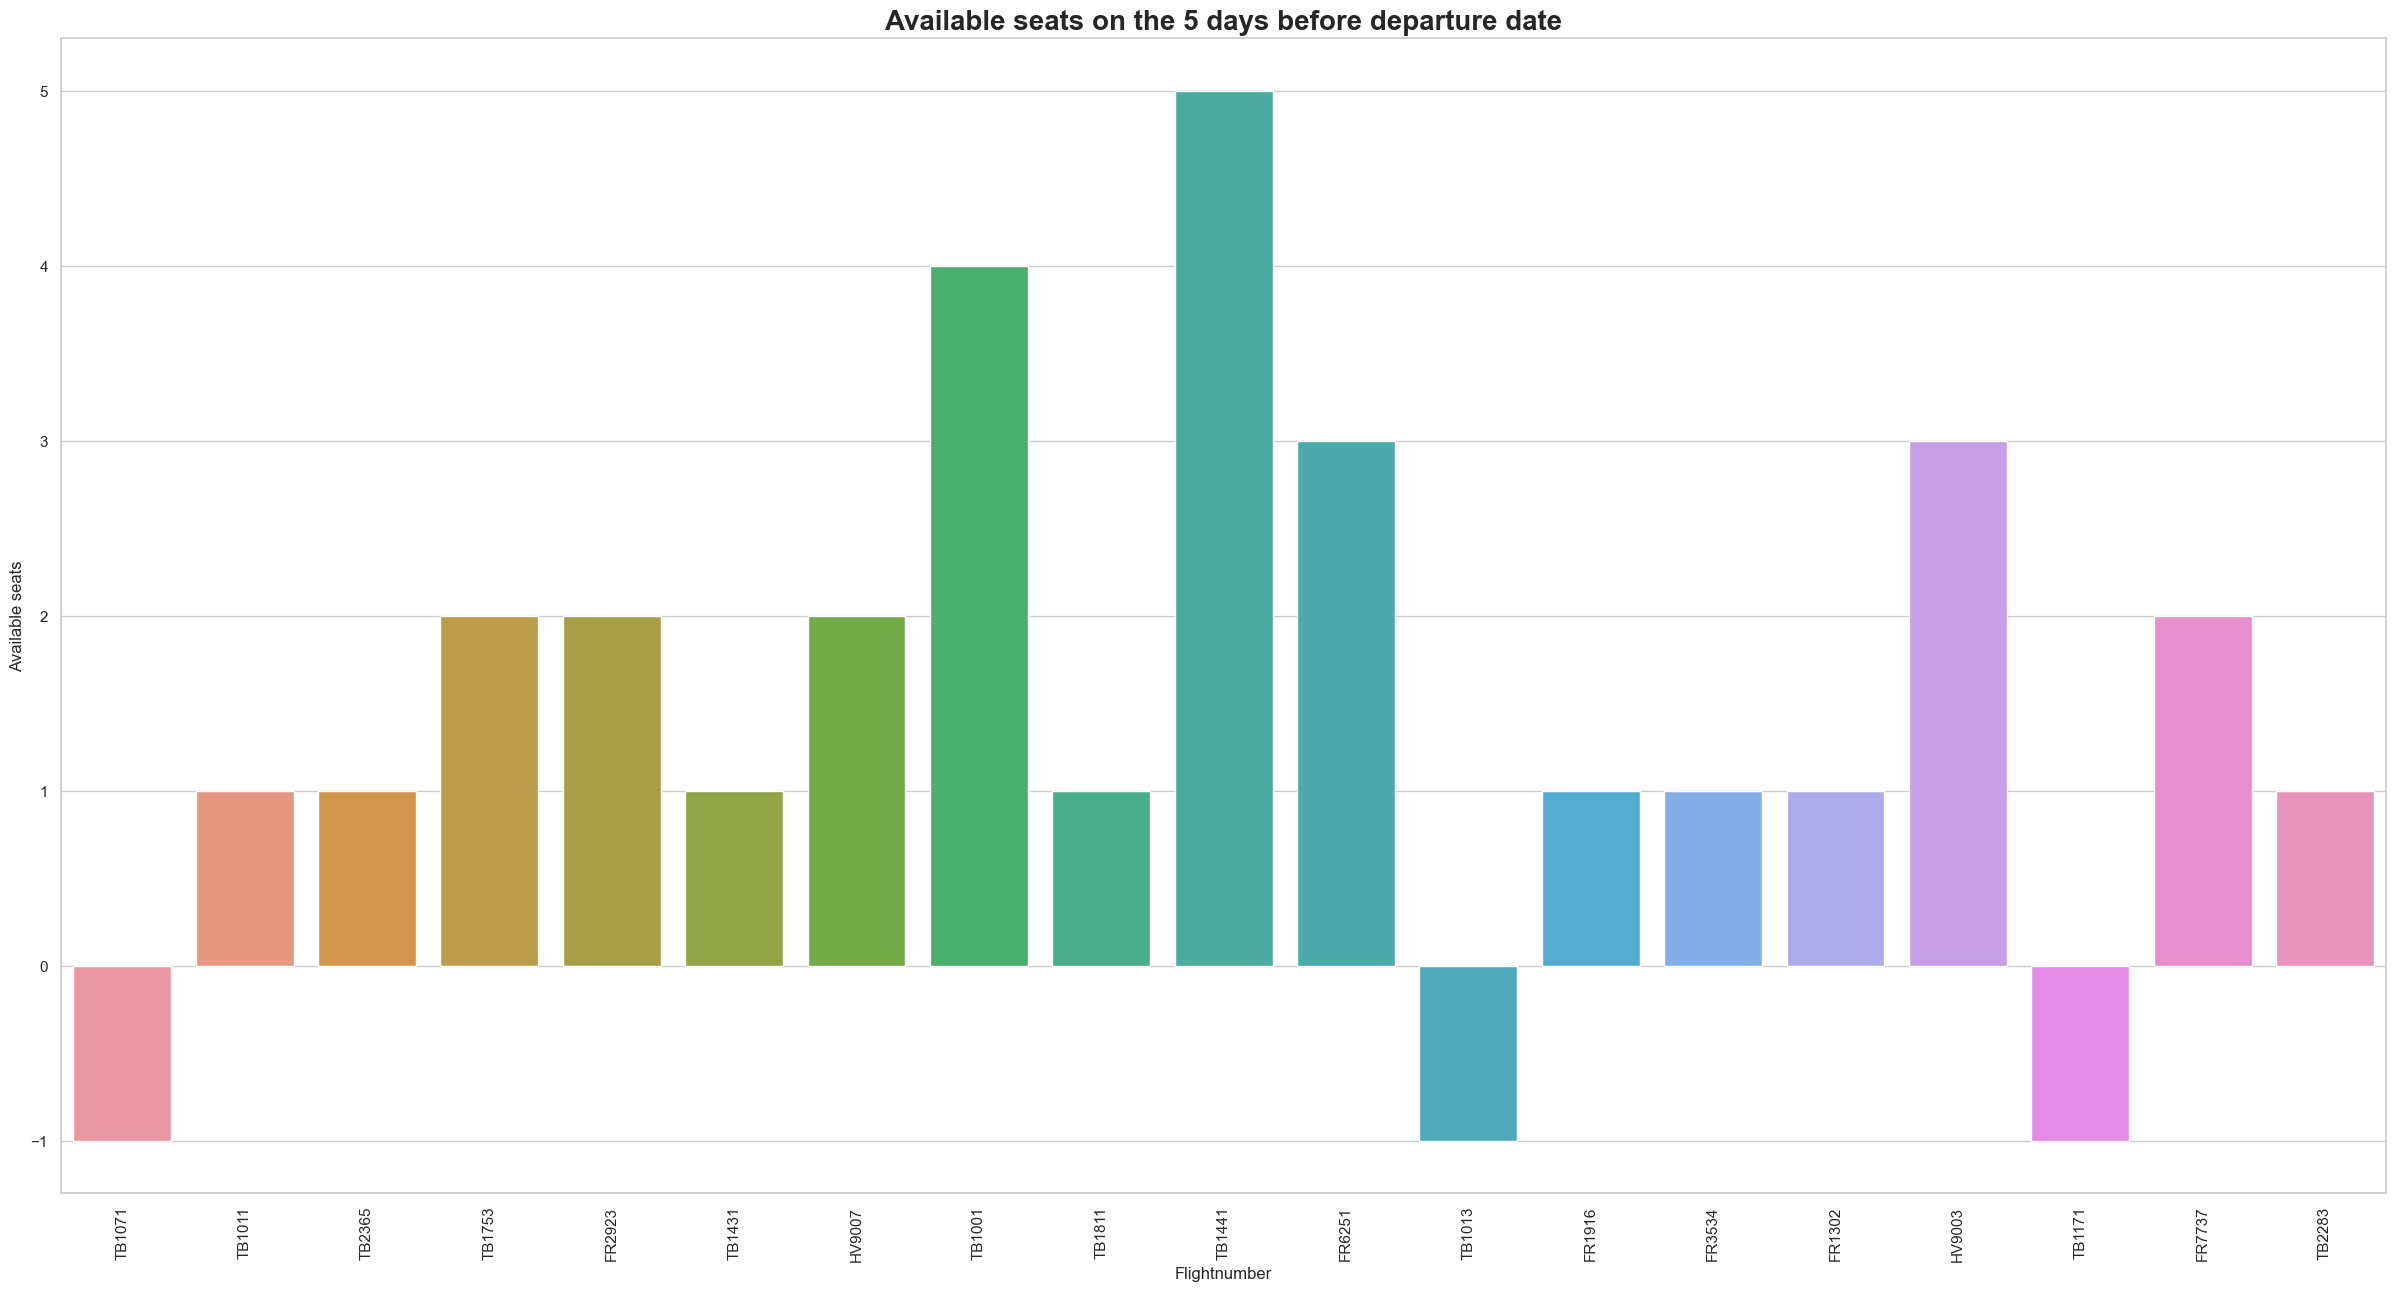

In [25]:
plt.figure(figsize=(30, 15))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="flightnumber", y="available_seats_fiveDays", data=data1)
ax.set_title('Available seats on the 5 days before departure date', fontsize=20, fontweight='bold')
ax.set_xlabel('Flightnumber')
ax.set_ylabel('Available seats')
plt.xticks(rotation=90)
y = data1['available_seats_fiveDays']
plt.yticks(range(int(min(y)), int(max(y)) + 1, 1))
plt.show()

### 14) Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand. Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand.

Plotten kan in zowel PowerBI als in Python, regressie is sowieso in Python

#### Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand.

Text(0, 0.5, 'Prijs (€)')

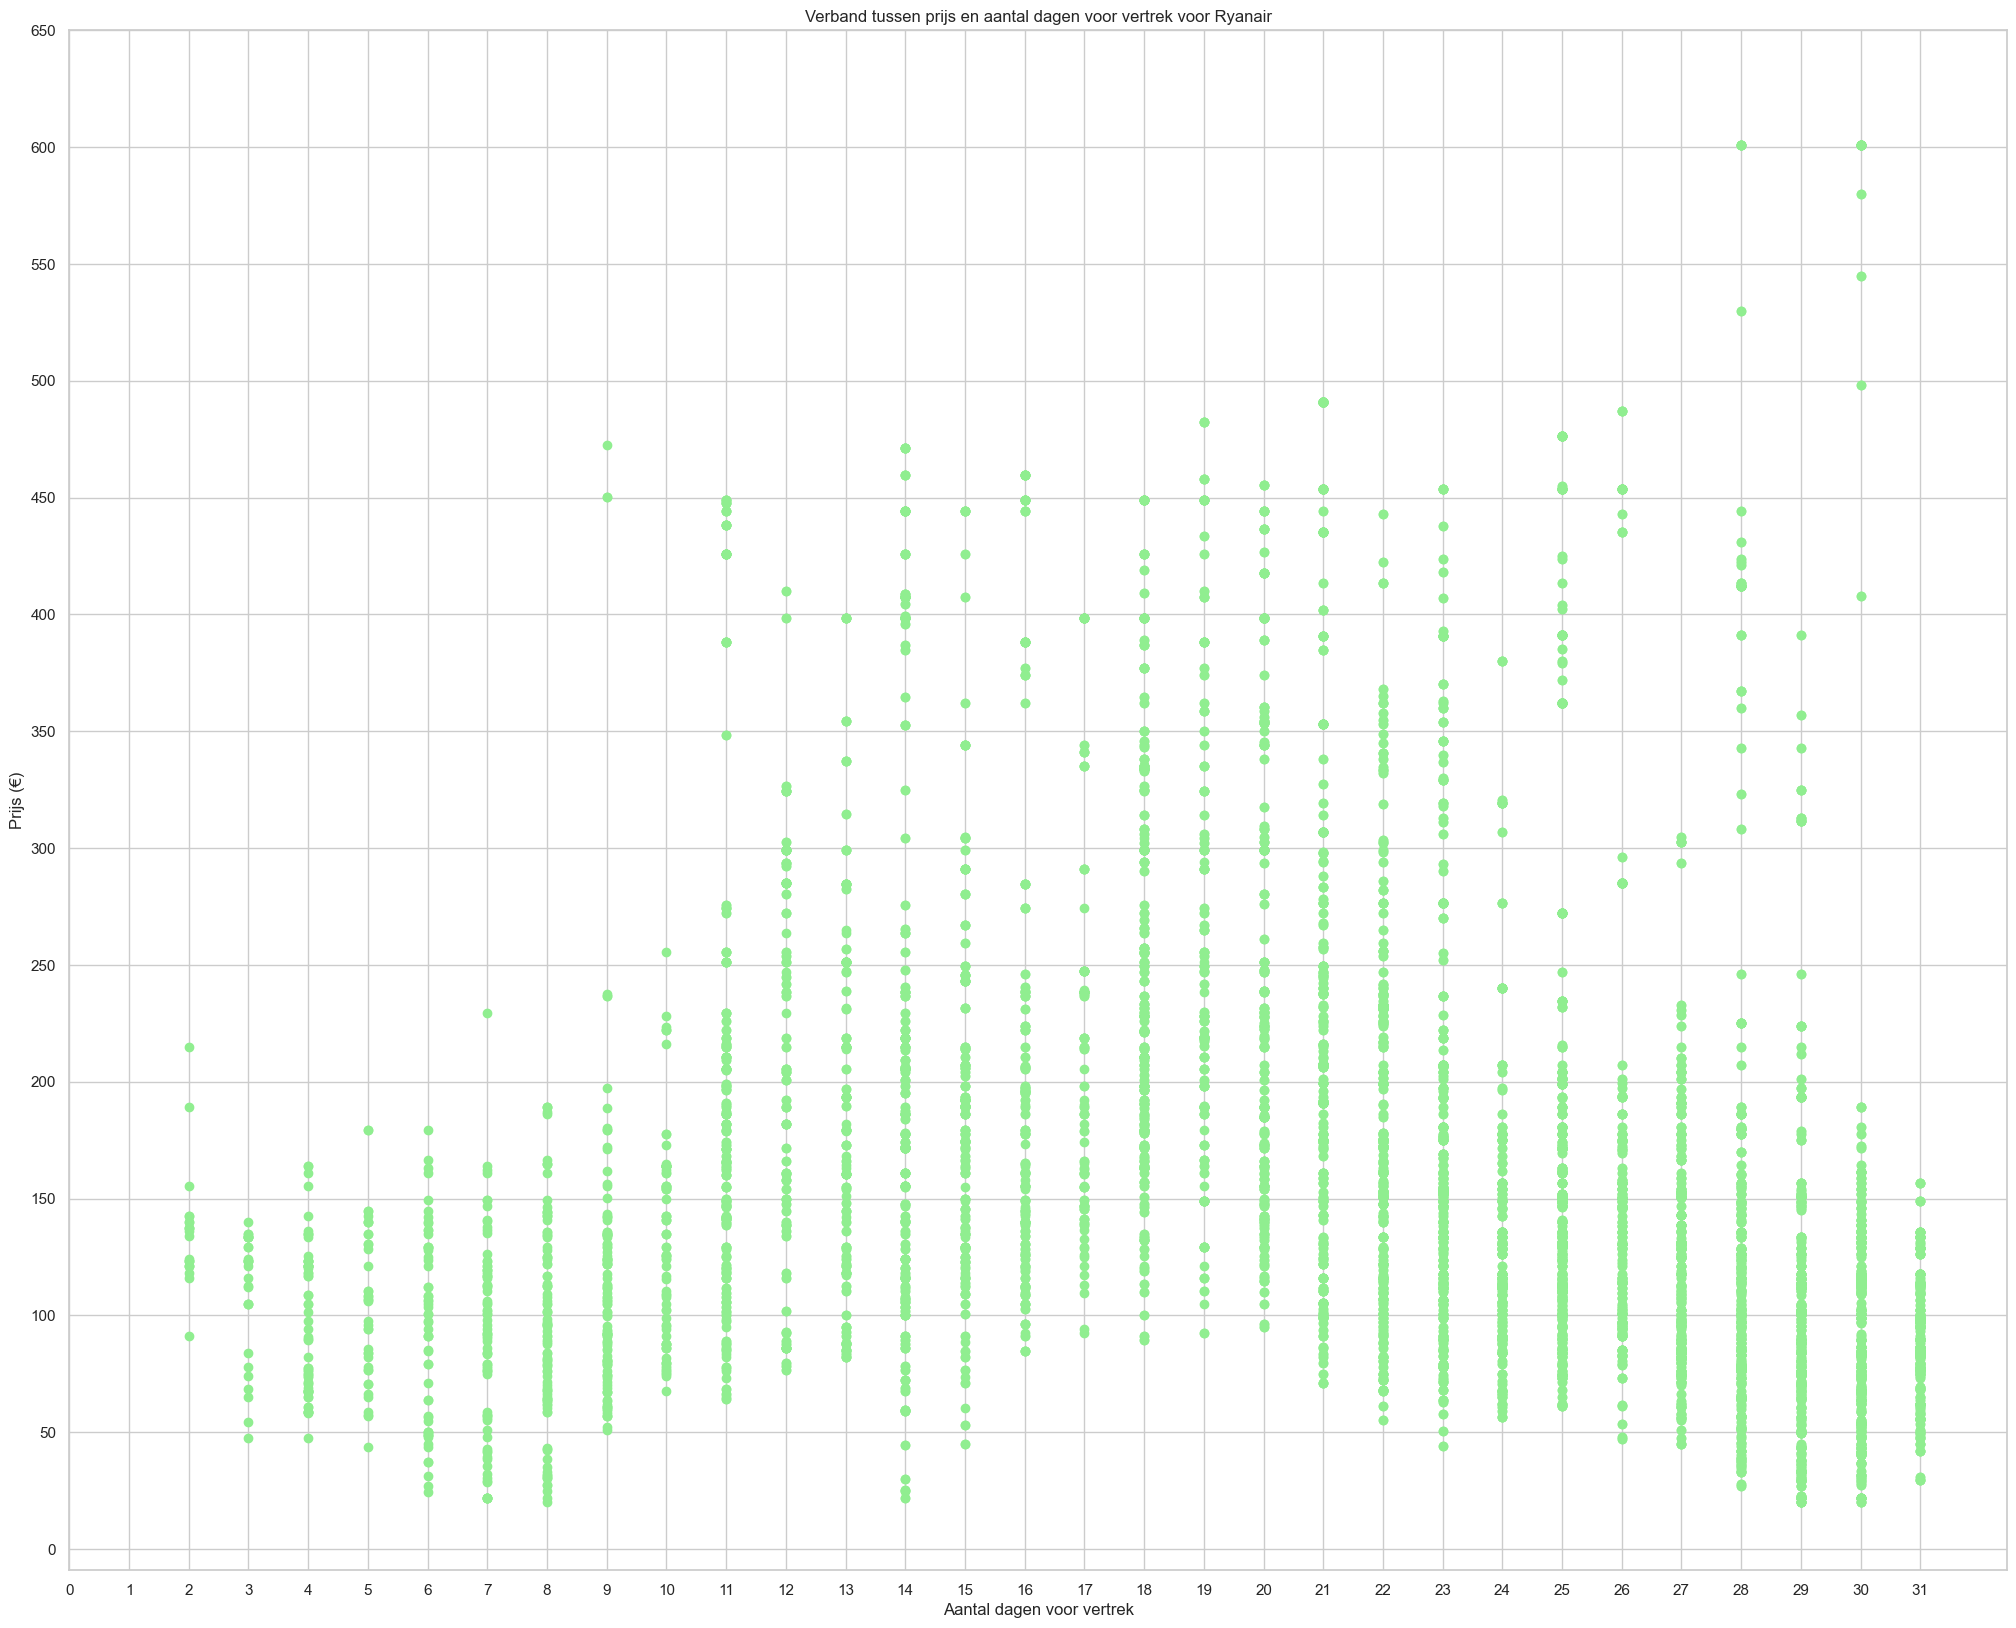

In [41]:
# read the data
data = df

# filter the data for Ryanair
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# add new column for days before departure
data['days_before_departure'] = (data['departure_date'] - data['departure_date'].min()).dt.days

# previous month with datetime
previous_month = datetime.datetime.now() - datetime.timedelta(days=30)

# today with datetime
today = datetime.datetime.now()

# filter the data for the last month ()
data = data[(data['departure_date'] >= previous_month) & (data['departure_date'] <= today)]

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot the results
sns.set_style('whitegrid')
plt.figure(figsize=(25, 20))
plt.plot(data['days_before_departure'], data['price'], 'o', color='lightgreen')
plt.title('Verband tussen prijs en aantal dagen voor vertrek voor Ryanair')
plt.xticks(range(0, 32, 1))
plt.xlabel('Aantal dagen voor vertrek')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')

#### Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand.

#### Linear Regression

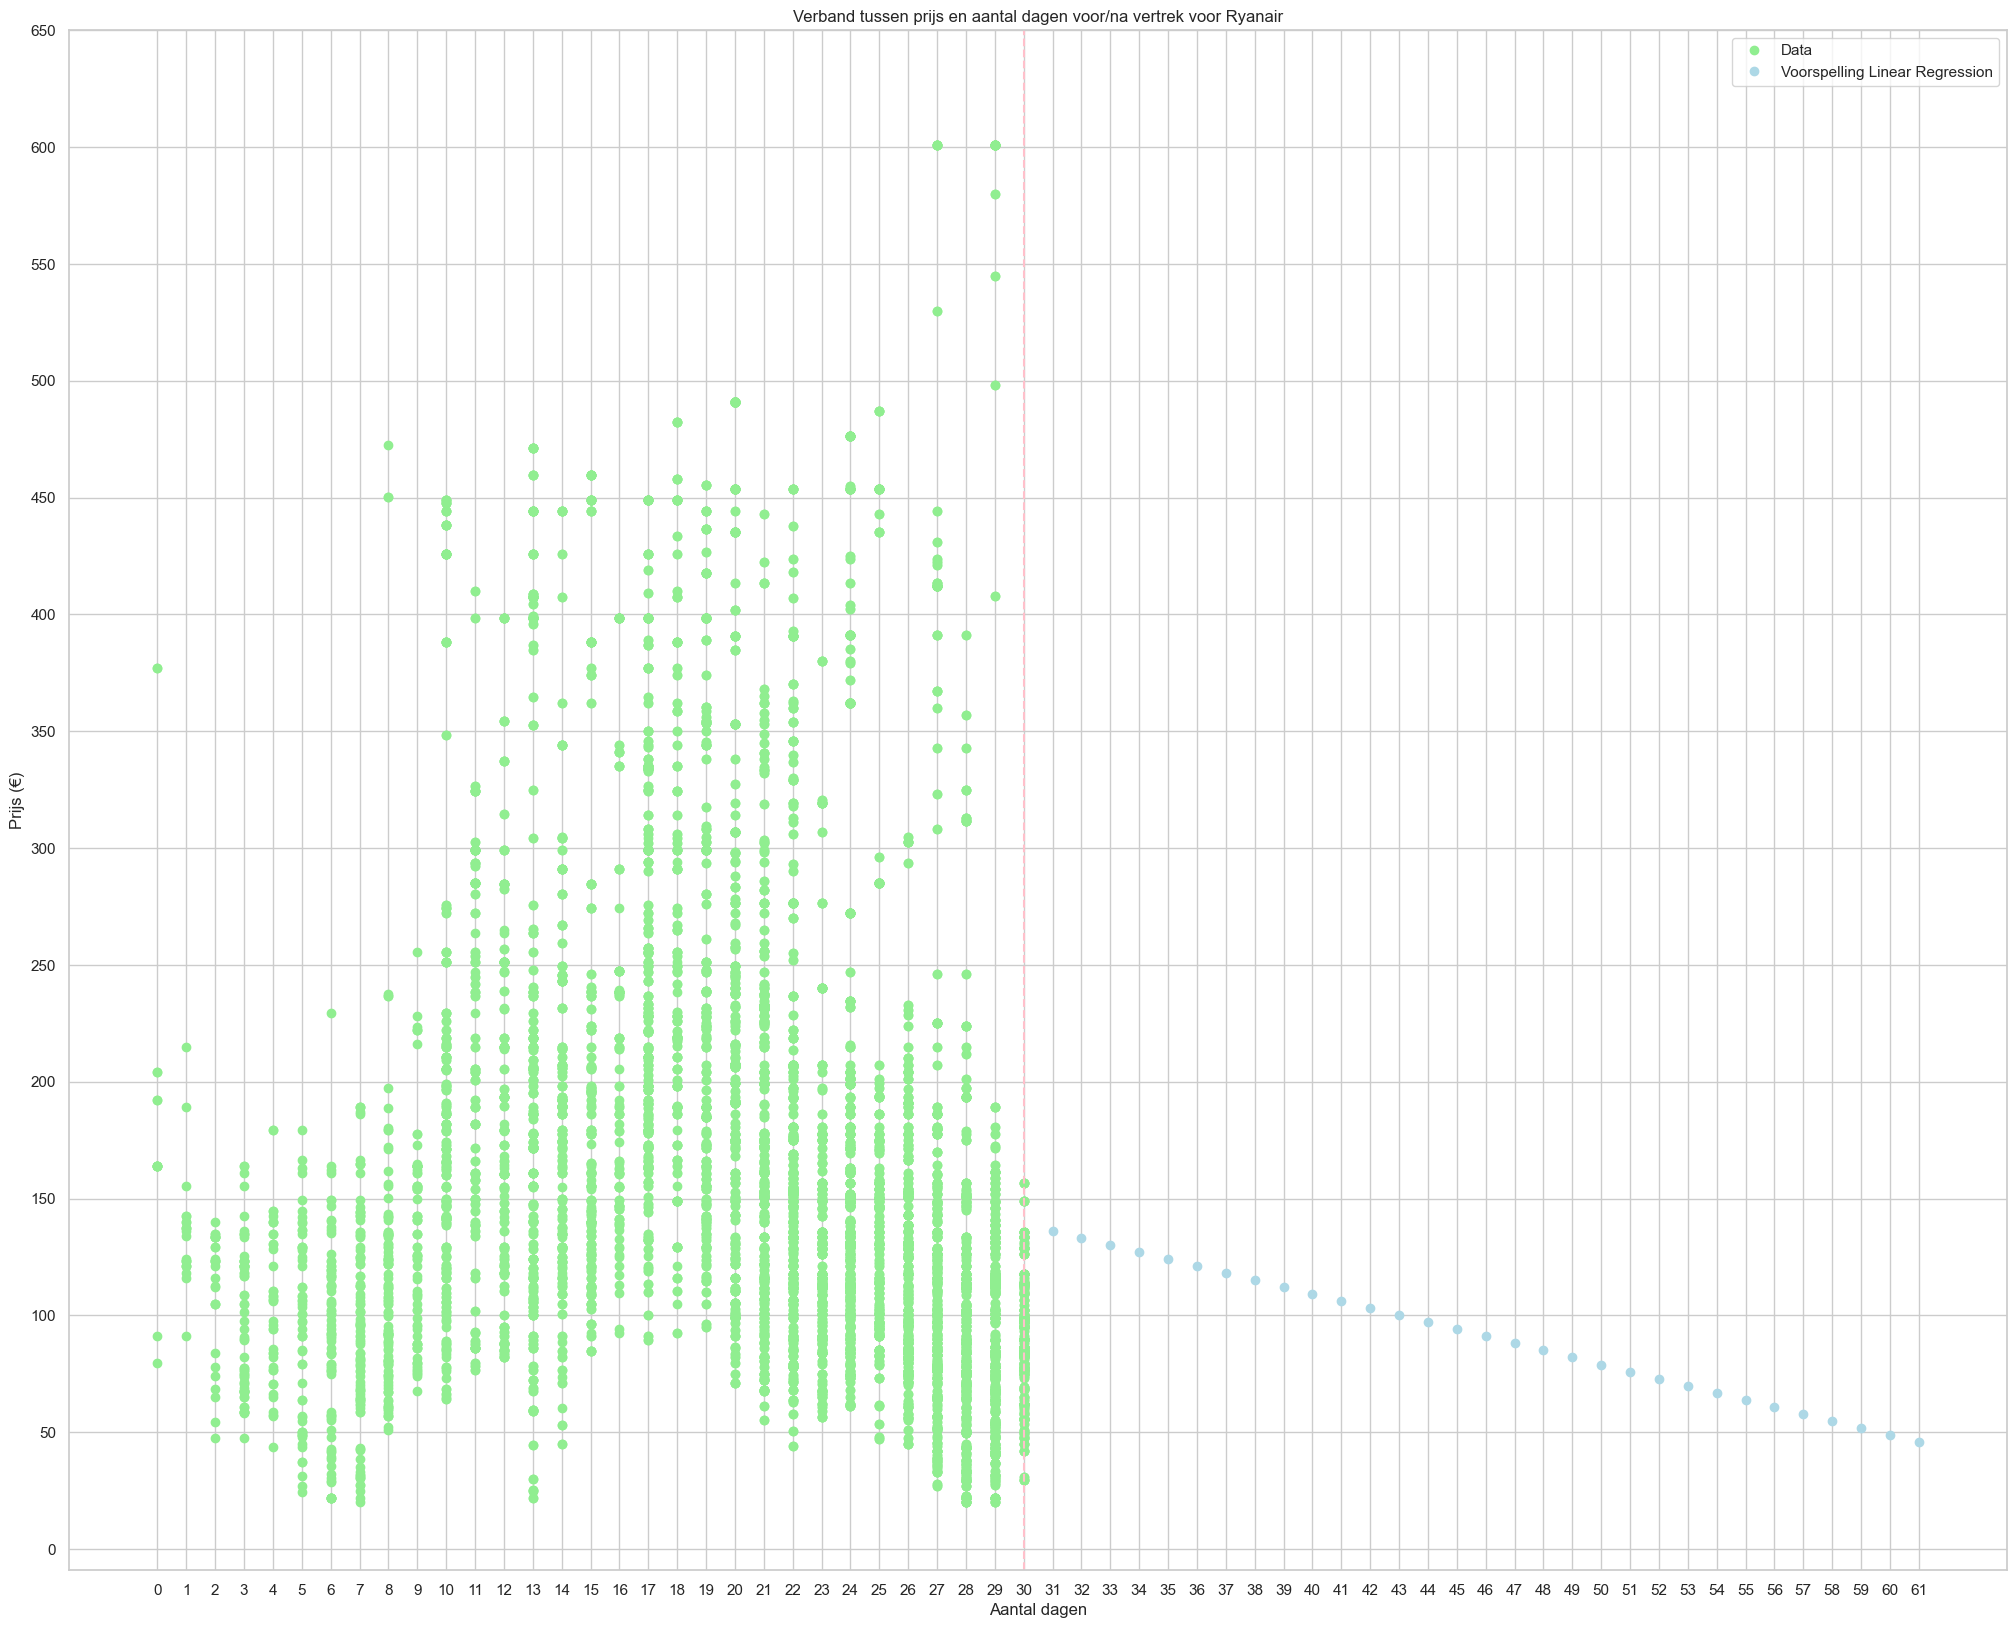

Accuracy score: 4.119267503692248 %
MSE: 9883.626973003127


In [42]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create linear regression model
lr = LinearRegression(n_jobs=-1)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
lr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_lr = lr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_lr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Linear Regression'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {lr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, lr.predict(X_train))}")

#### Random Forest Regression

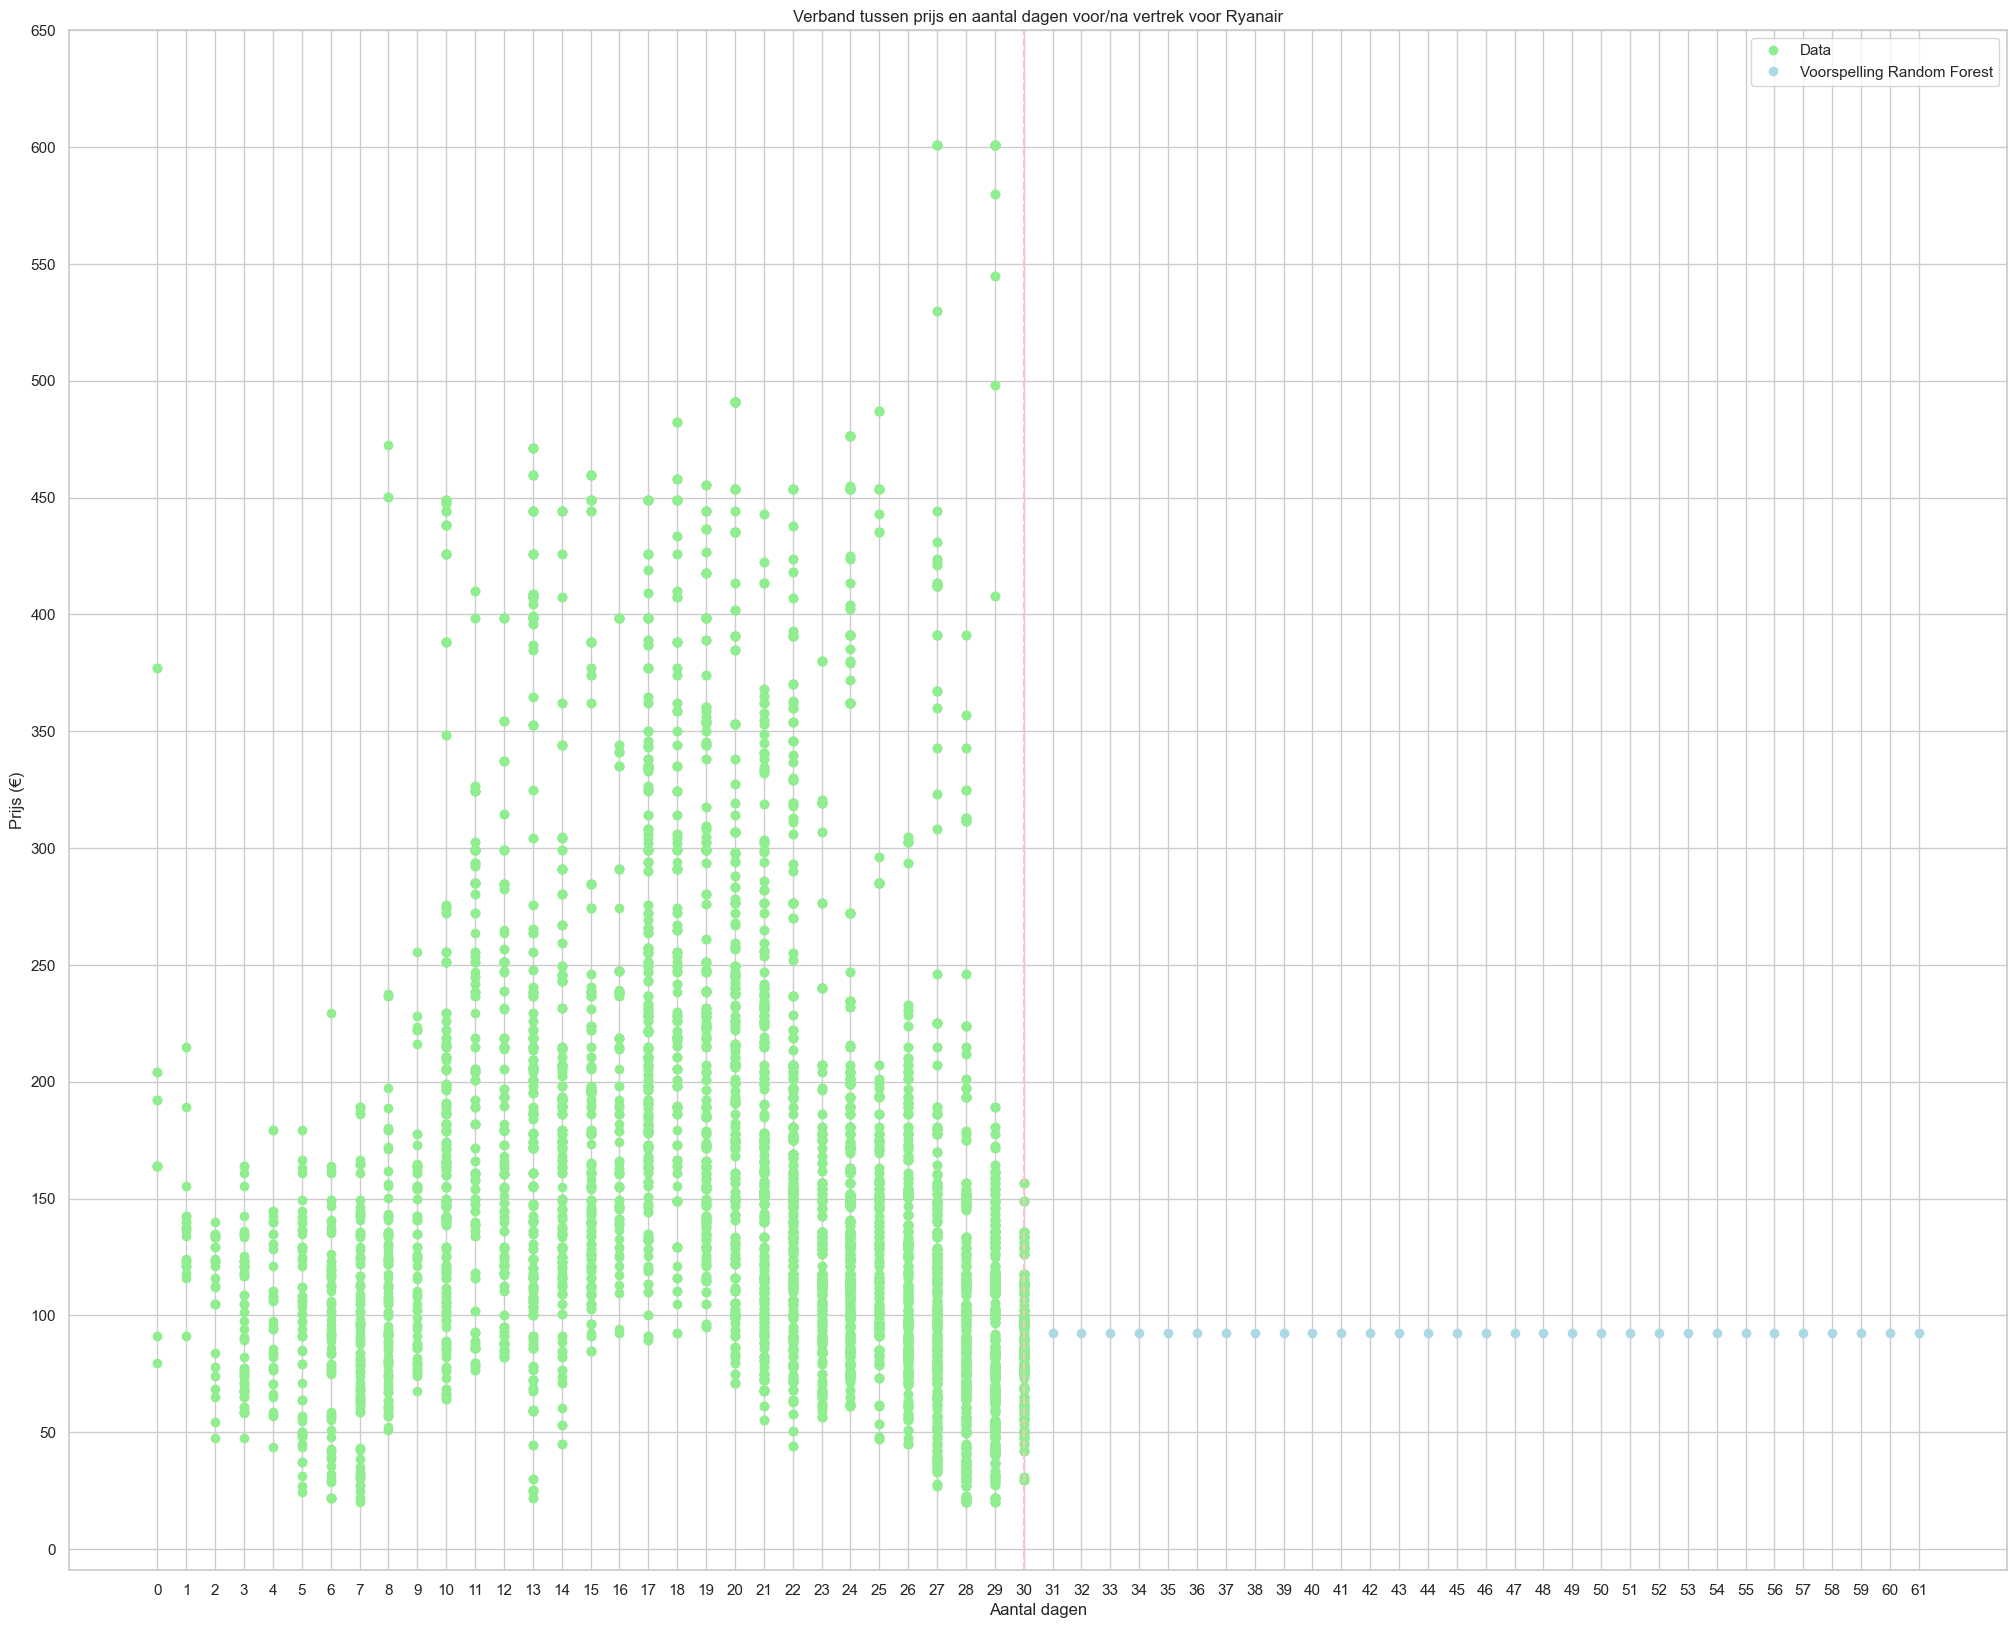

Accuracy score: 25.73174838659703 %
MSE: 7655.75810460438


In [43]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create random forest regression model
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
rfr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_rfr = rfr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_rfr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Random Forest'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {rfr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, rfr.predict(X_train))}")

#### Hard Voting

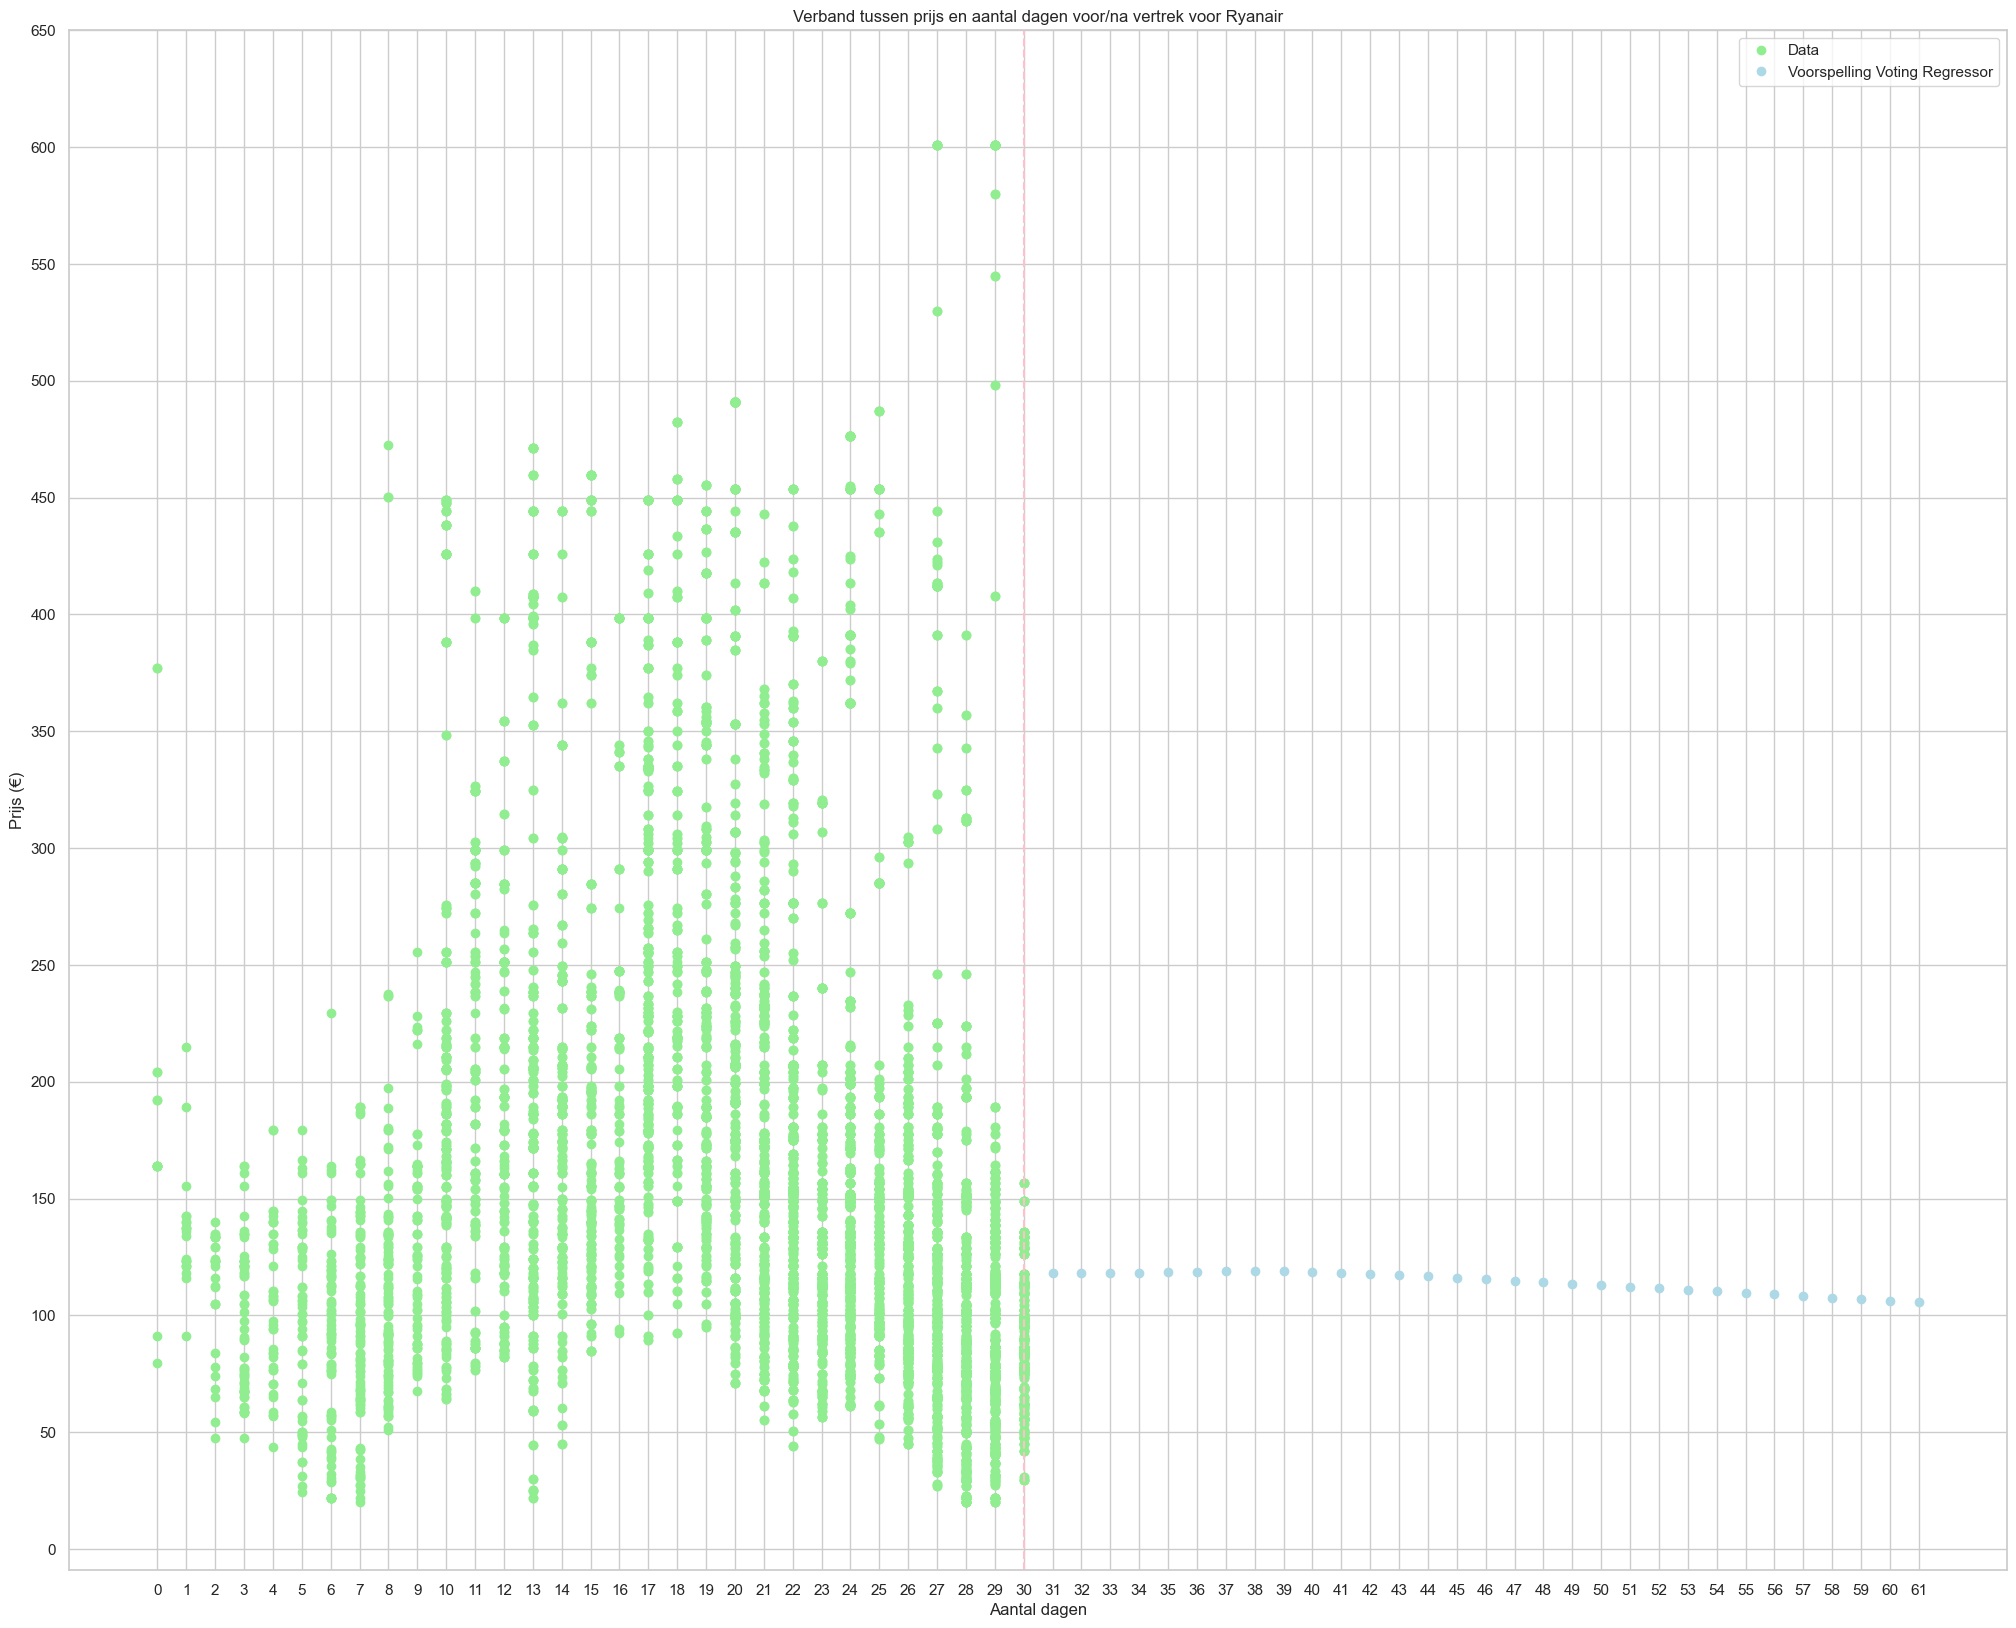

Accuracy score: 22.192972559773406 %
MSE: 8020.544014169184


In [44]:
# create the regression models
lr = LinearRegression(n_jobs=-1)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
gb = GradientBoostingRegressor(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
sgd = SGDRegressor(random_state=42)
svr = SVR()

# create the voting regressor
vr = VotingRegressor([('lr', lr), ('rf', rf), ('gb', gb), ('dt', dt), ('sgd', sgd), ('svr', svr)])

# fit the model
vr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_vr = vr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_vr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Voting Regressor'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {vr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, vr.predict(X_train))}")

#### Decision Tree Regressor

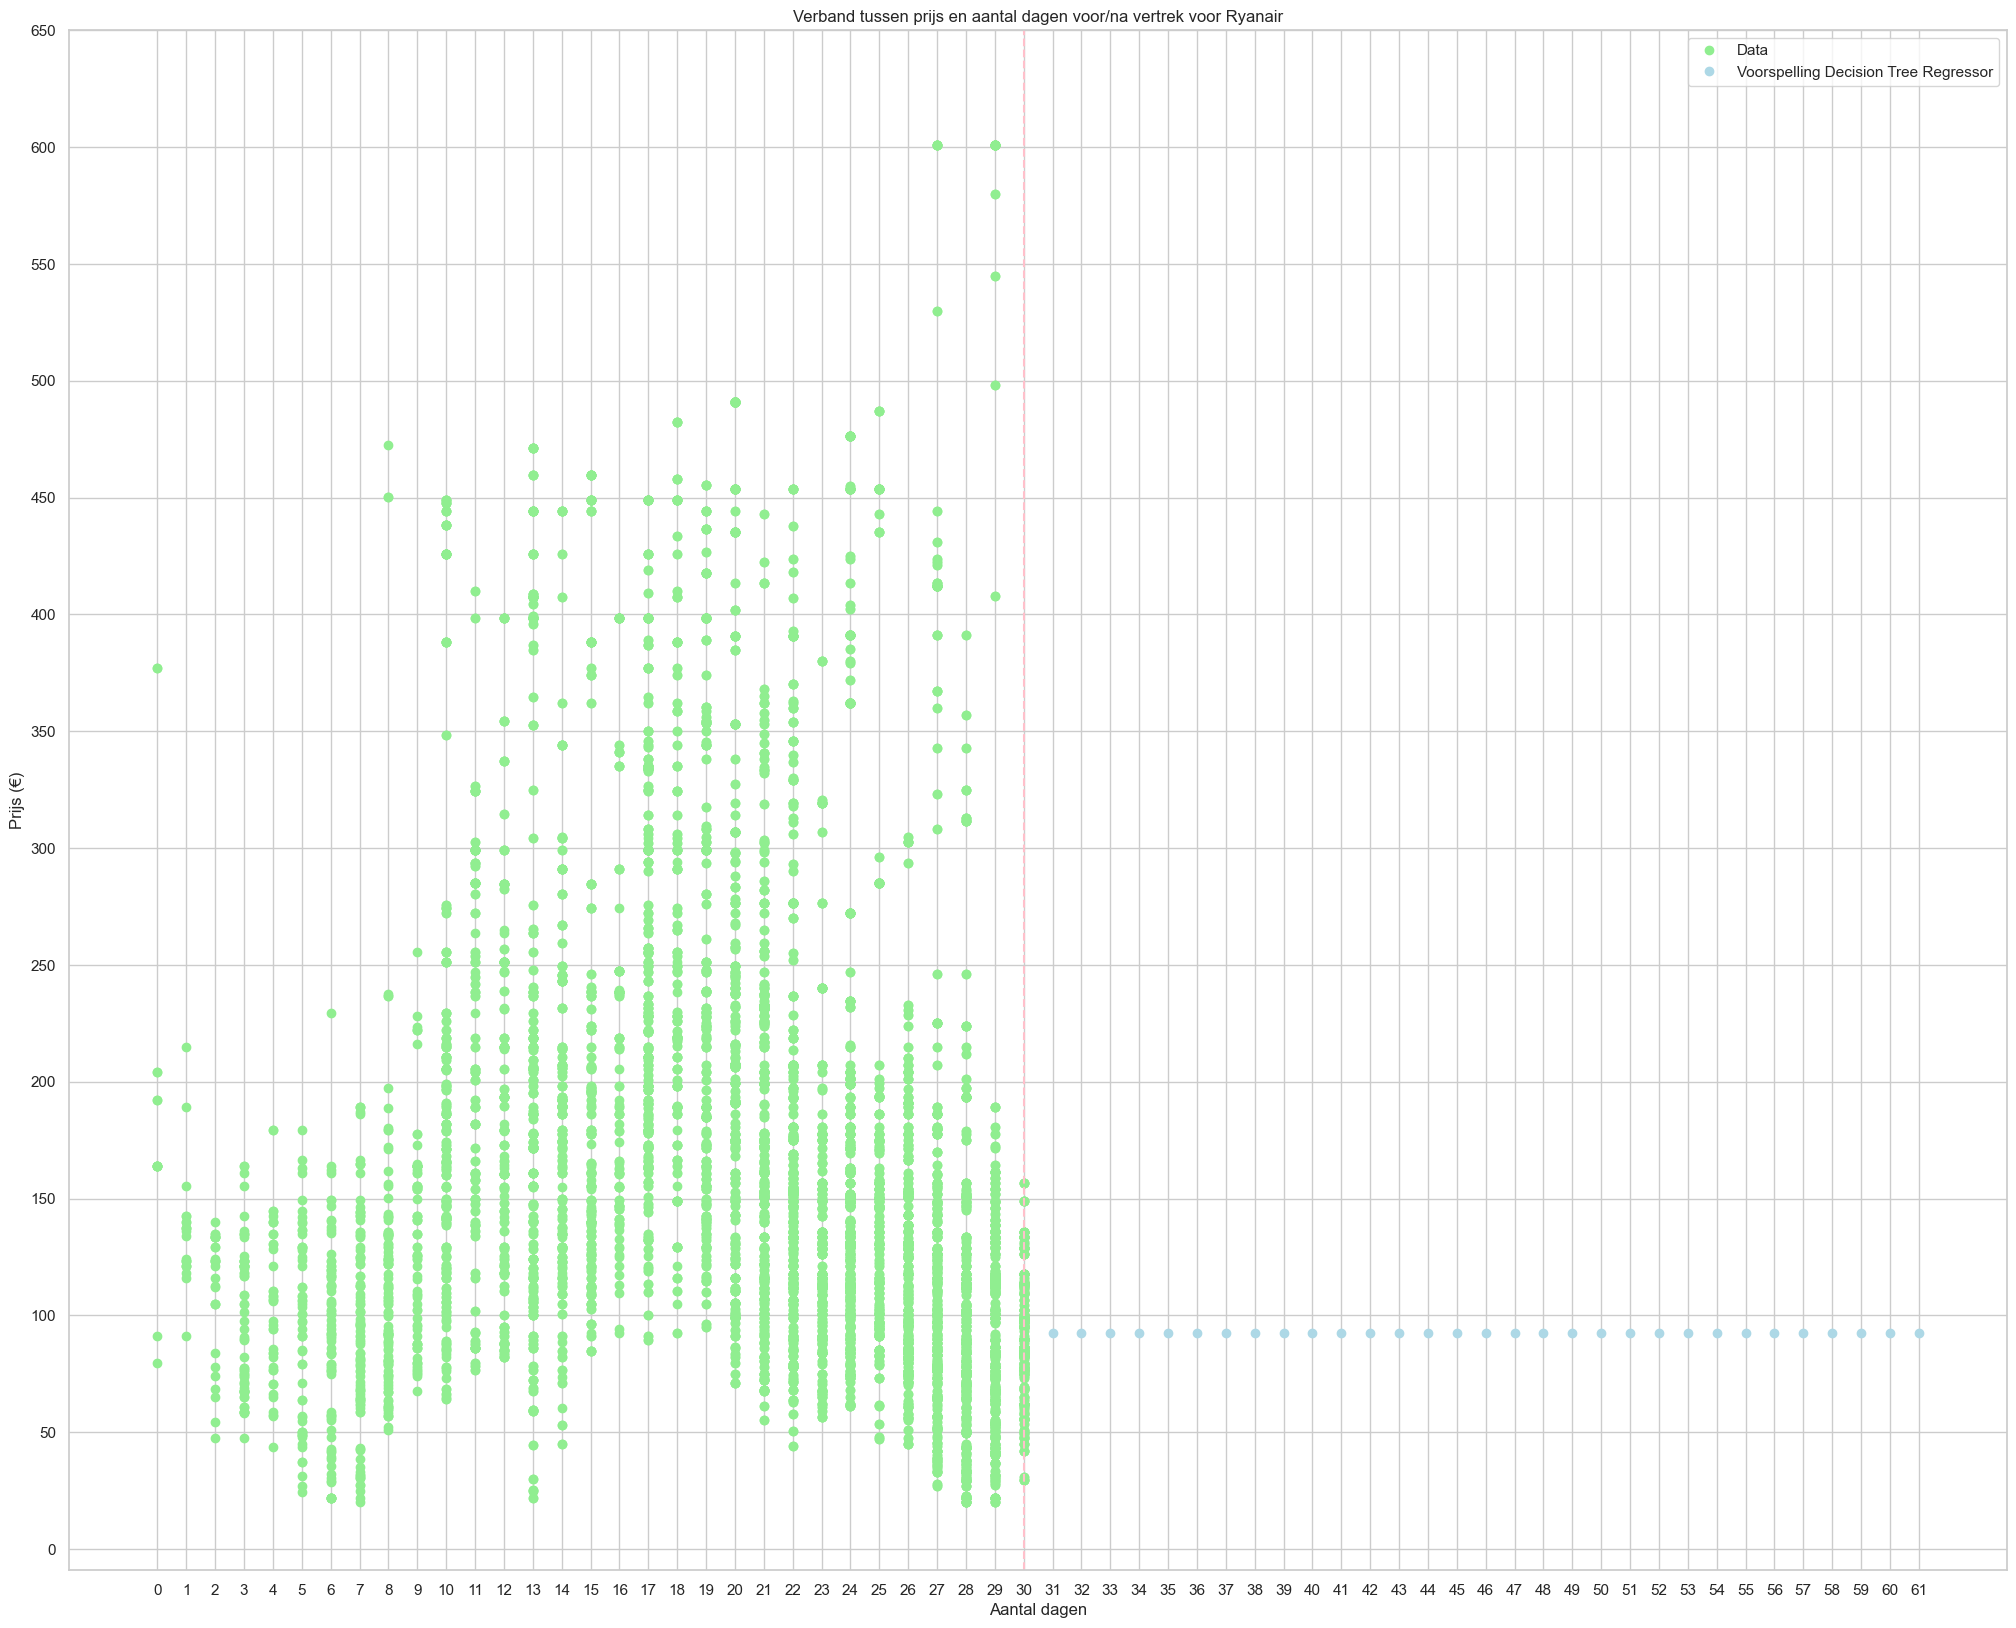

Accuracy score: 25.73387721359336 %
MSE: 7655.538659765214


In [45]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create decision tree regression model
dtr = DecisionTreeRegressor(random_state=42)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
dtr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_dtr = dtr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_dtr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Decision Tree Regressor'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {dtr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, dtr.predict(X_train))}")

#### Gradient Boosting Regressor

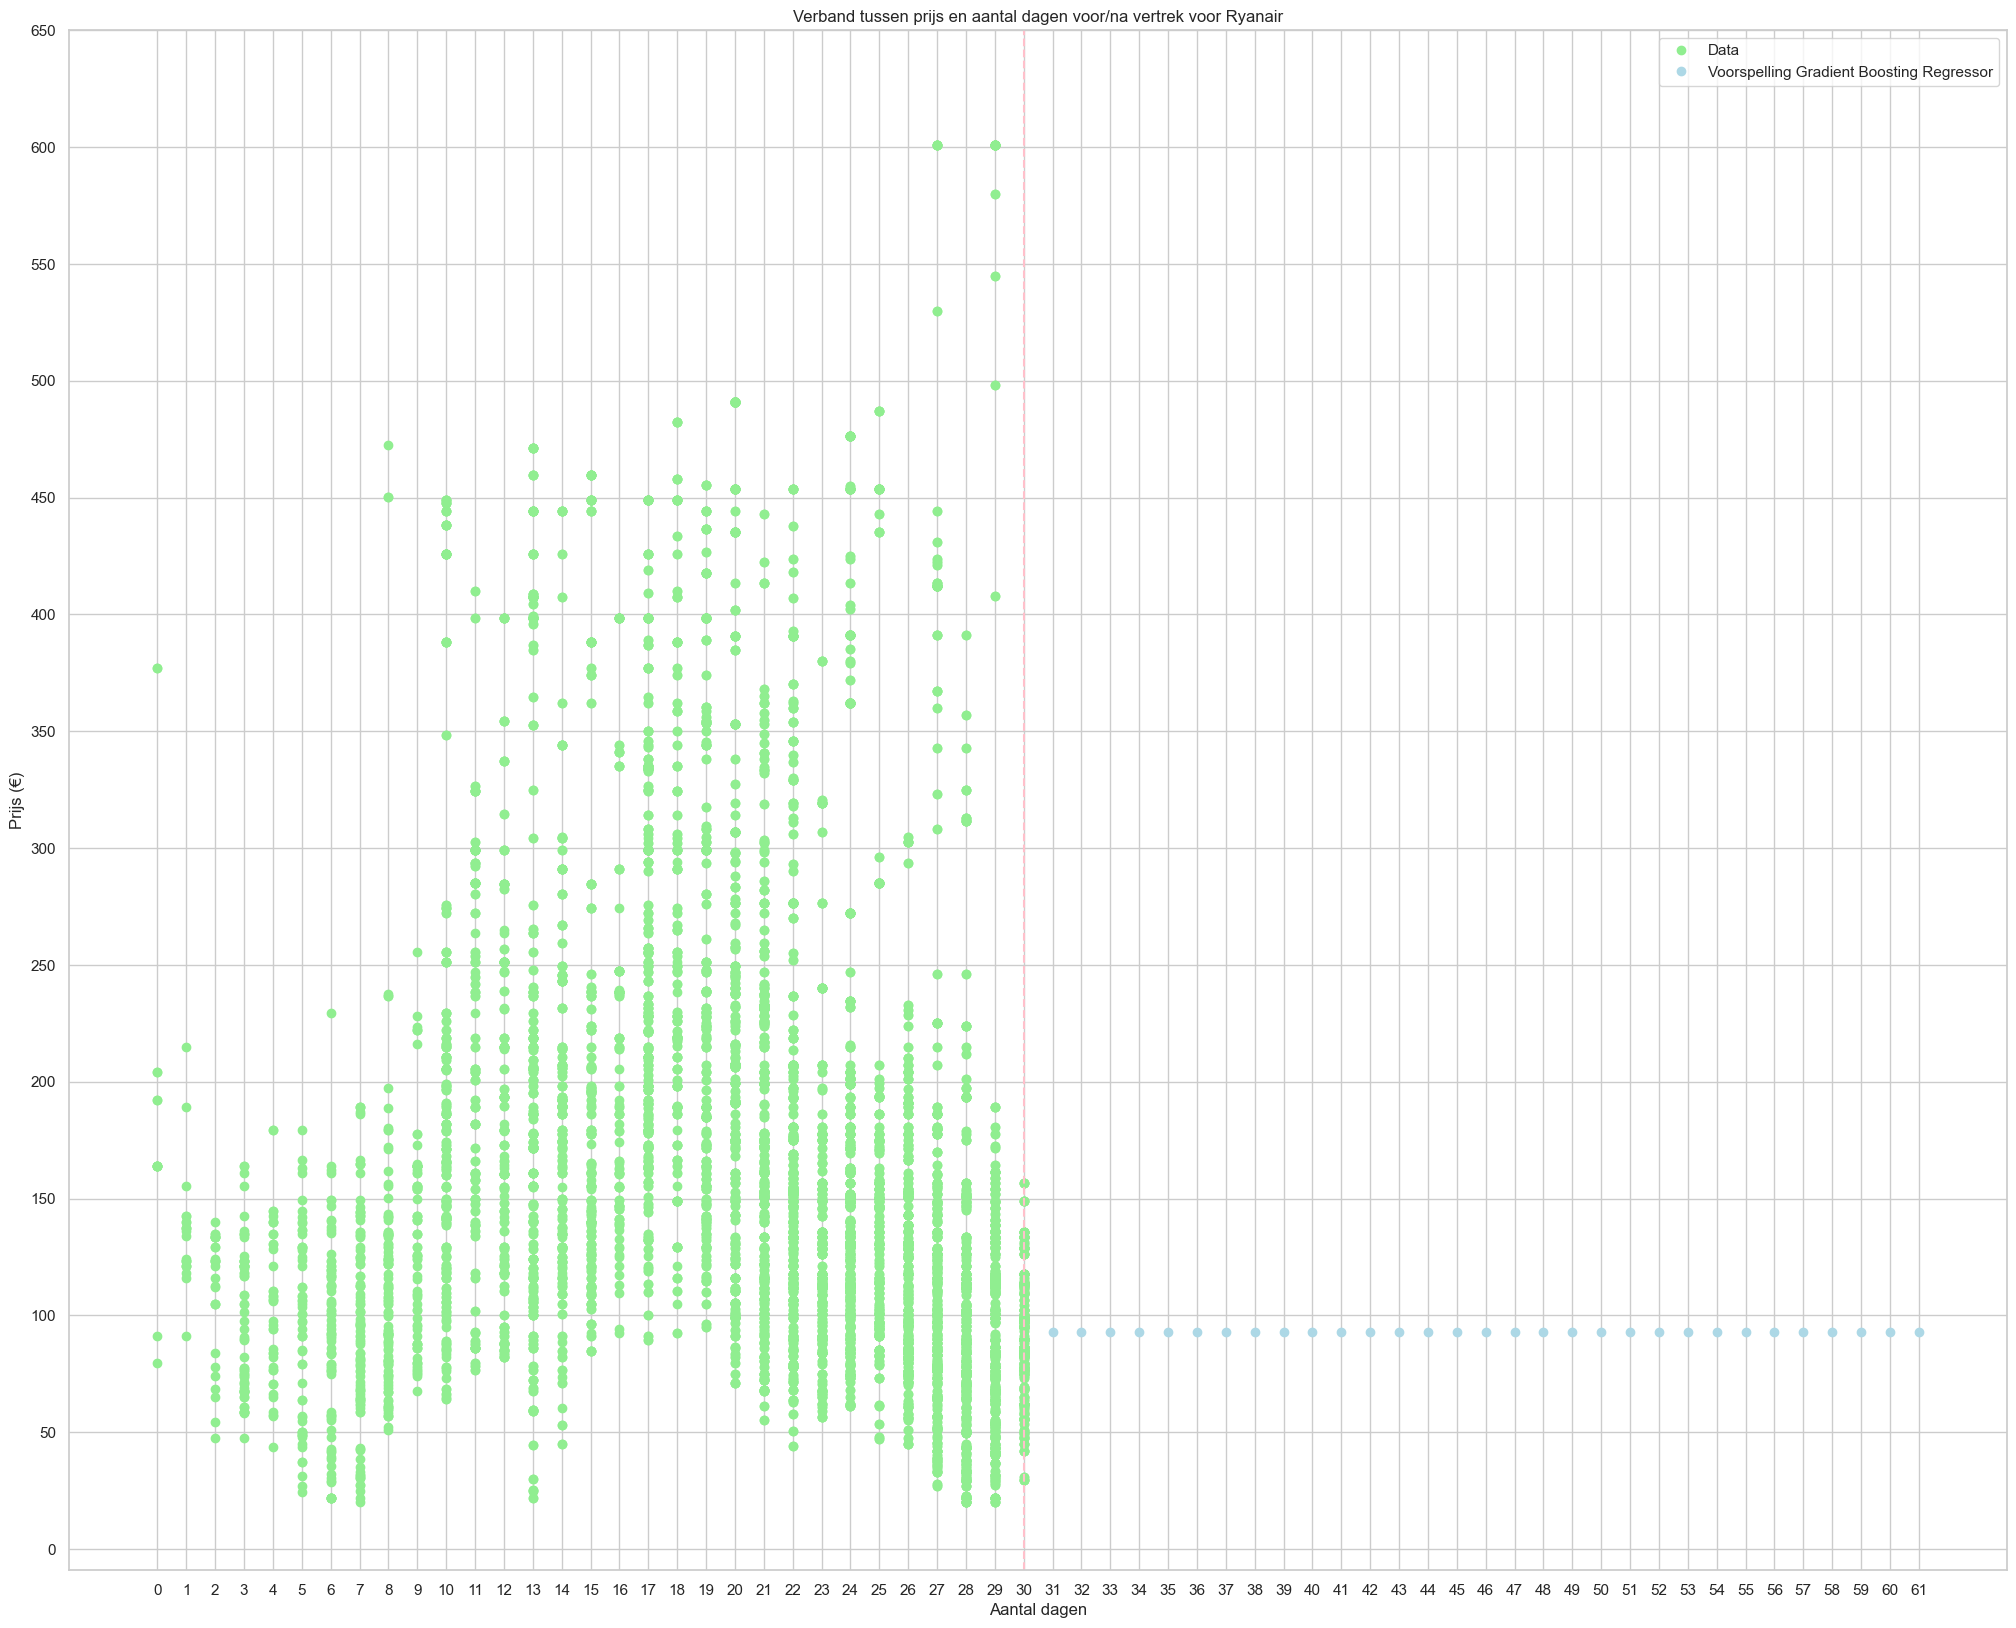

Accuracy score: 25.72479605916017 %
MSE: 7656.474767996398


In [46]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create gradient boosting regression model
gbr = GradientBoostingRegressor(random_state=42)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
gbr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_gbr = gbr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_gbr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Gradient Boosting Regressor'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {gbr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, gbr.predict(X_train))}")

#### Stochastic Gradient Descent Regressor

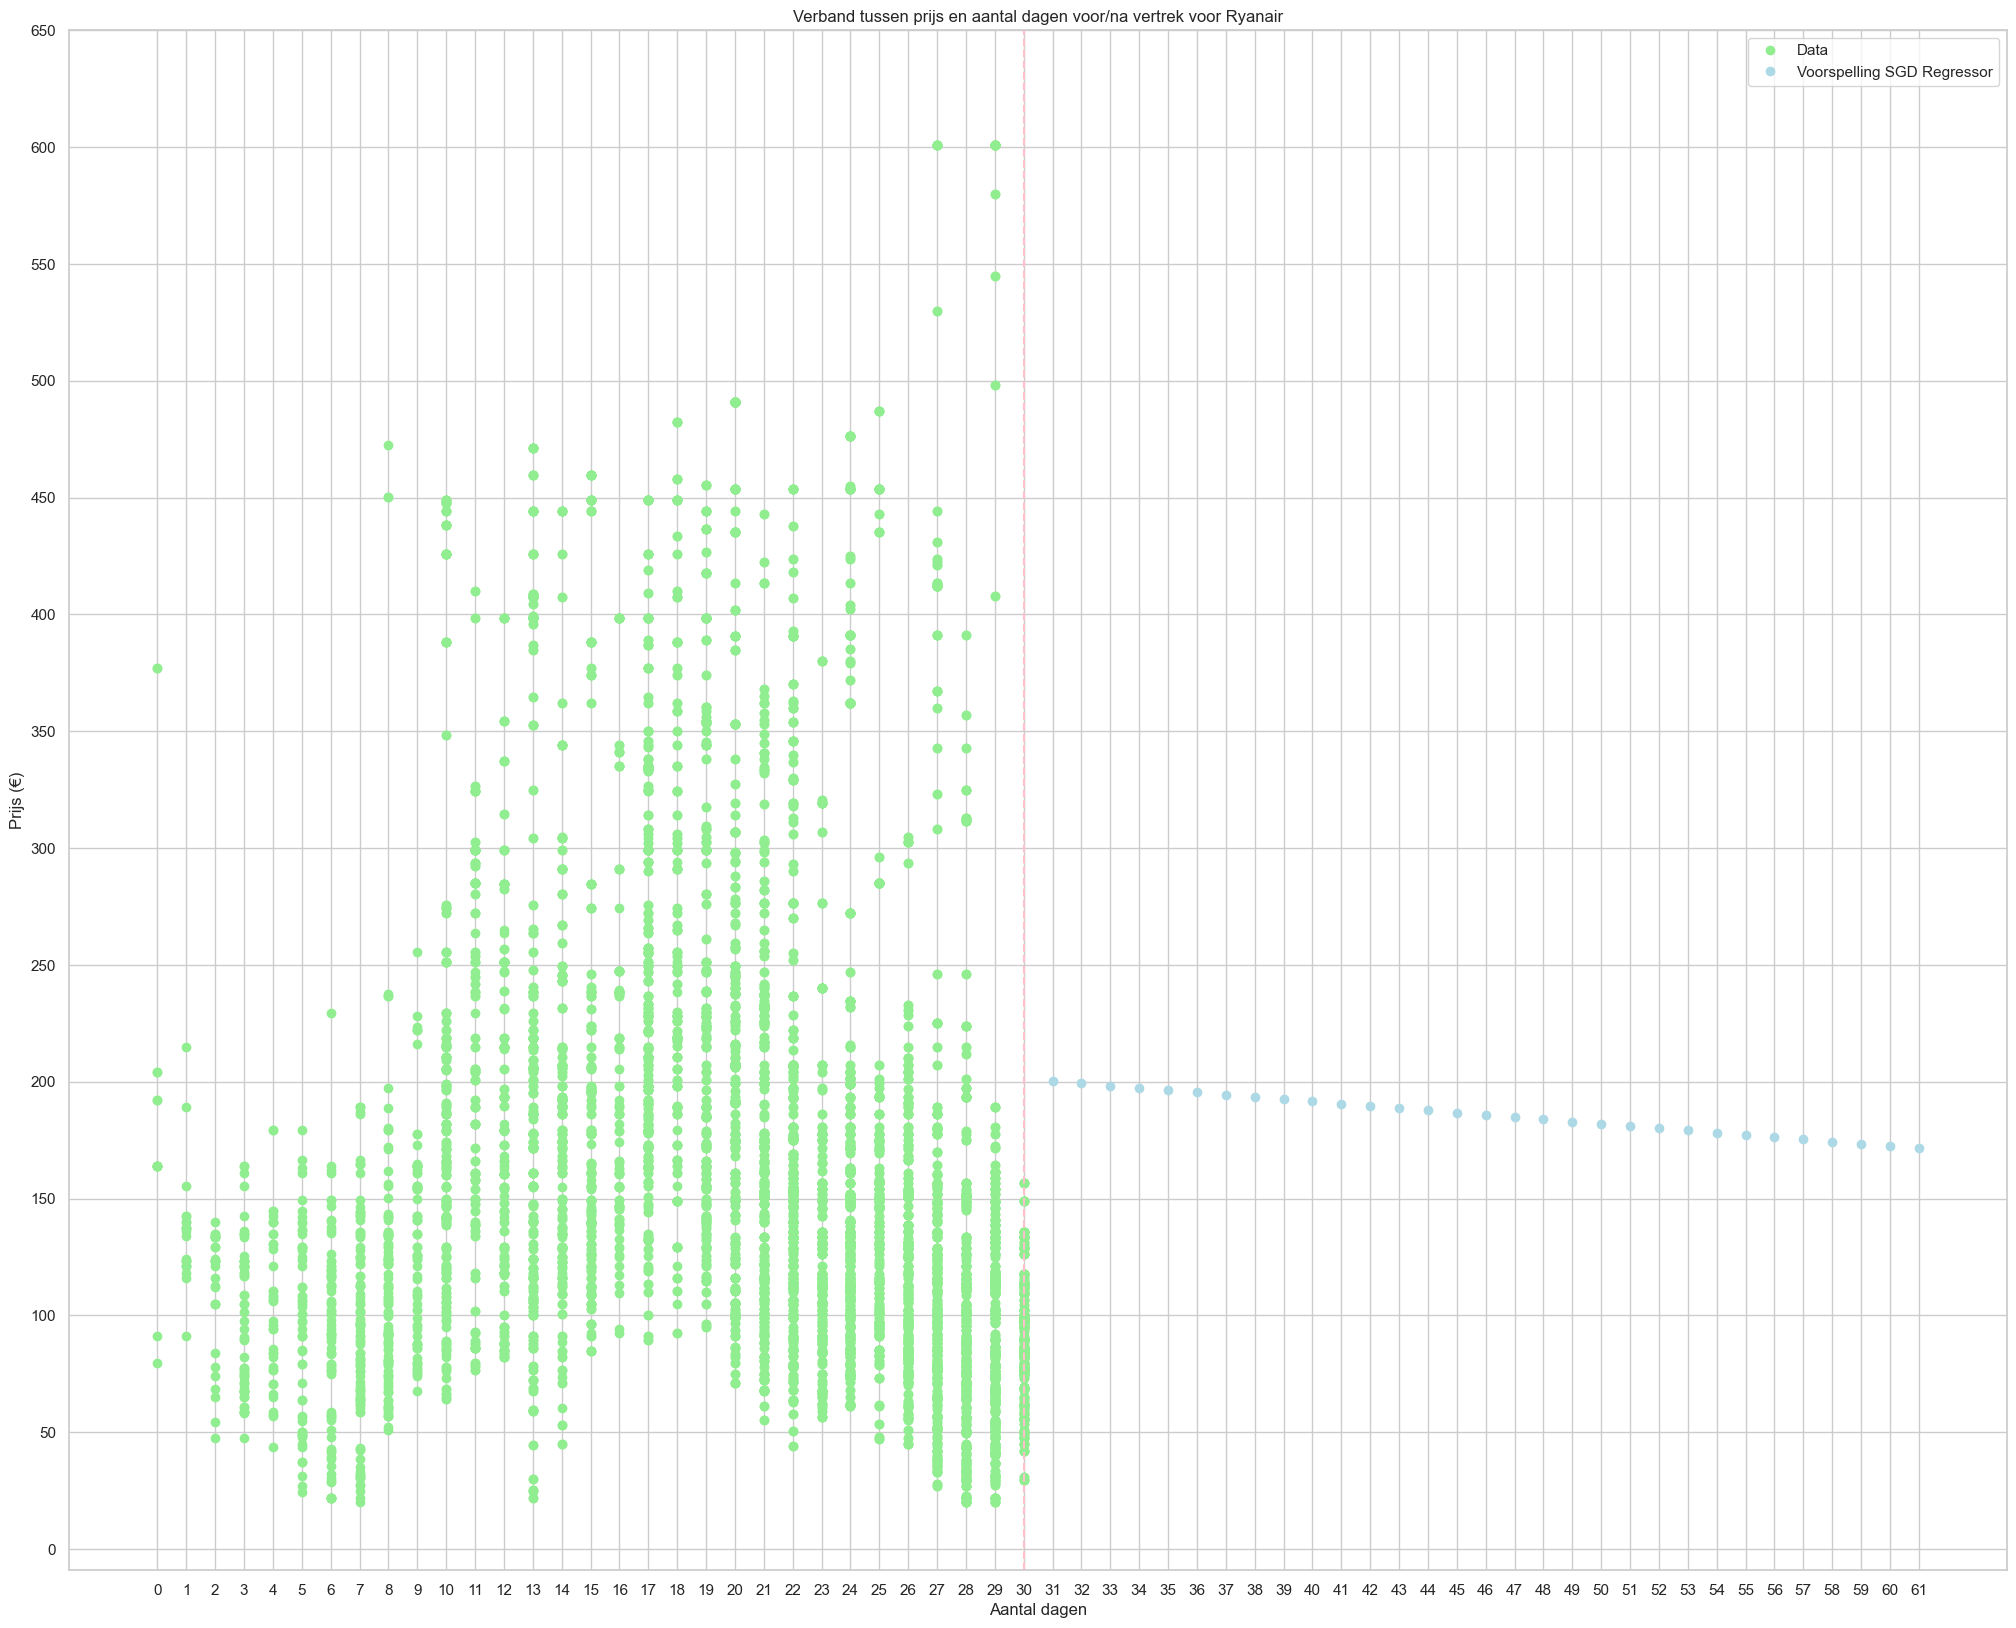

Accuracy score: -15.77240725534288 %
MSE: 11934.110819631811


In [47]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create sgd regression model
sgd = SGDRegressor(random_state=42)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
sgd.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_sgd = sgd.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_sgd, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling SGD Regressor'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {sgd.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, sgd.predict(X_train))}")

#### SVR

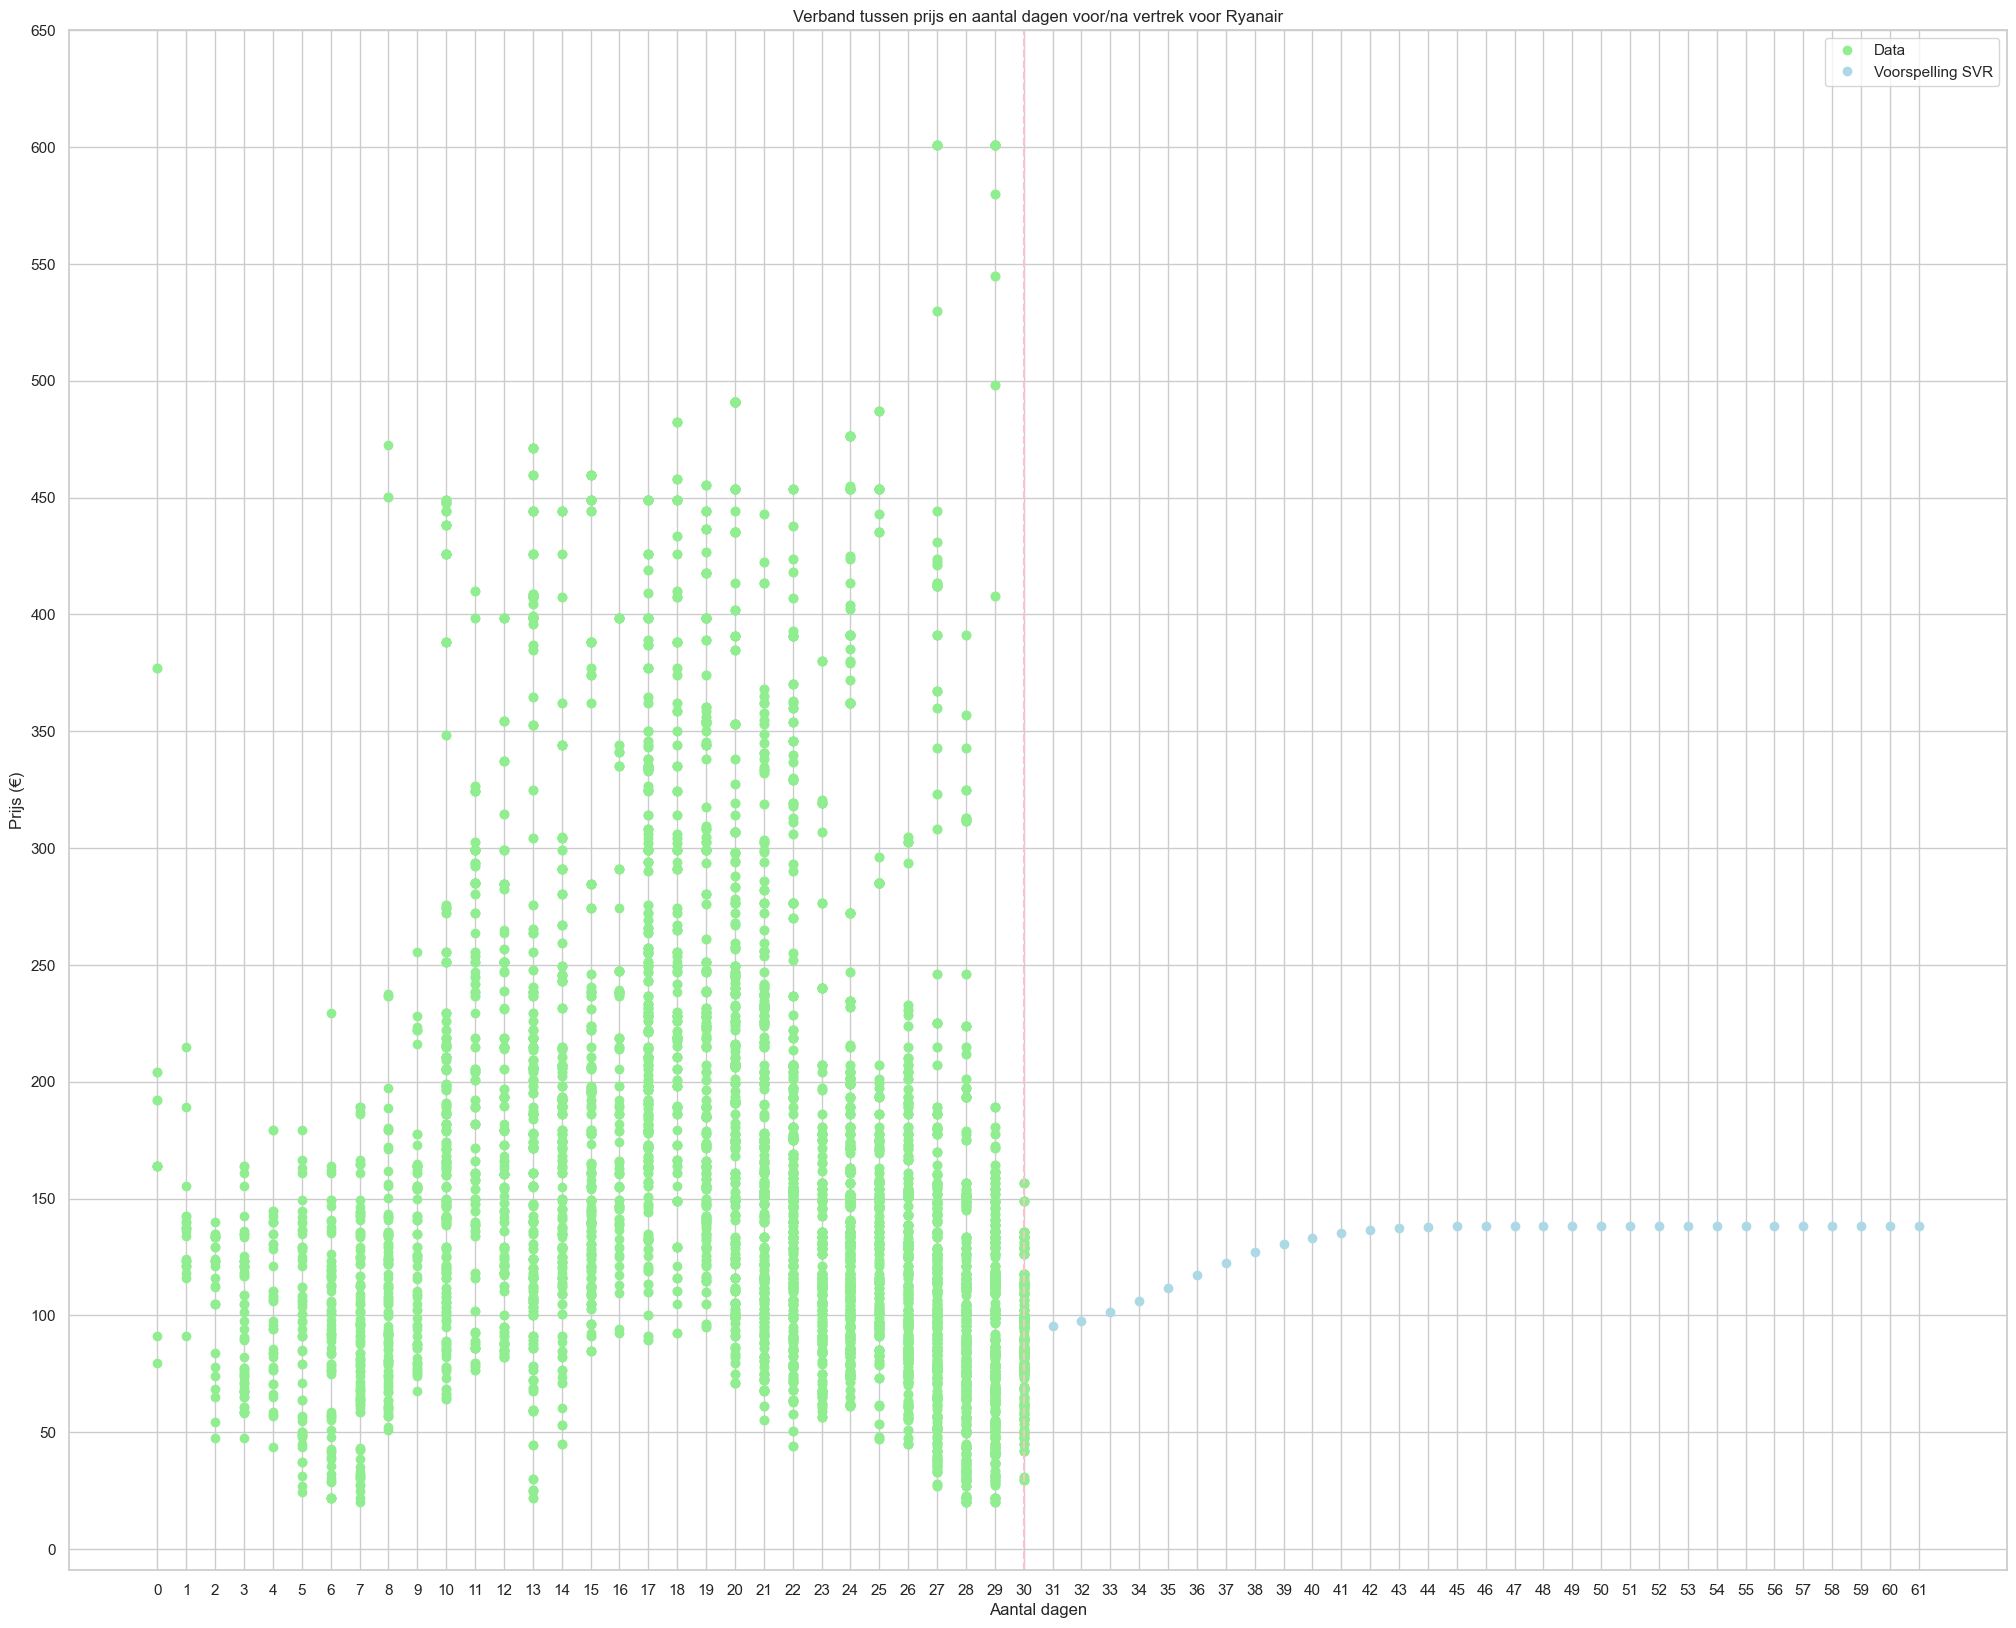

Accuracy score: 17.521009615118665 %
MSE: 8502.14170094571


In [48]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create svr regression model
svr = SVR()

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
svr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_svr = svr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_svr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling SVR'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {svr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, svr.predict(X_train))}")

#### Grid Search

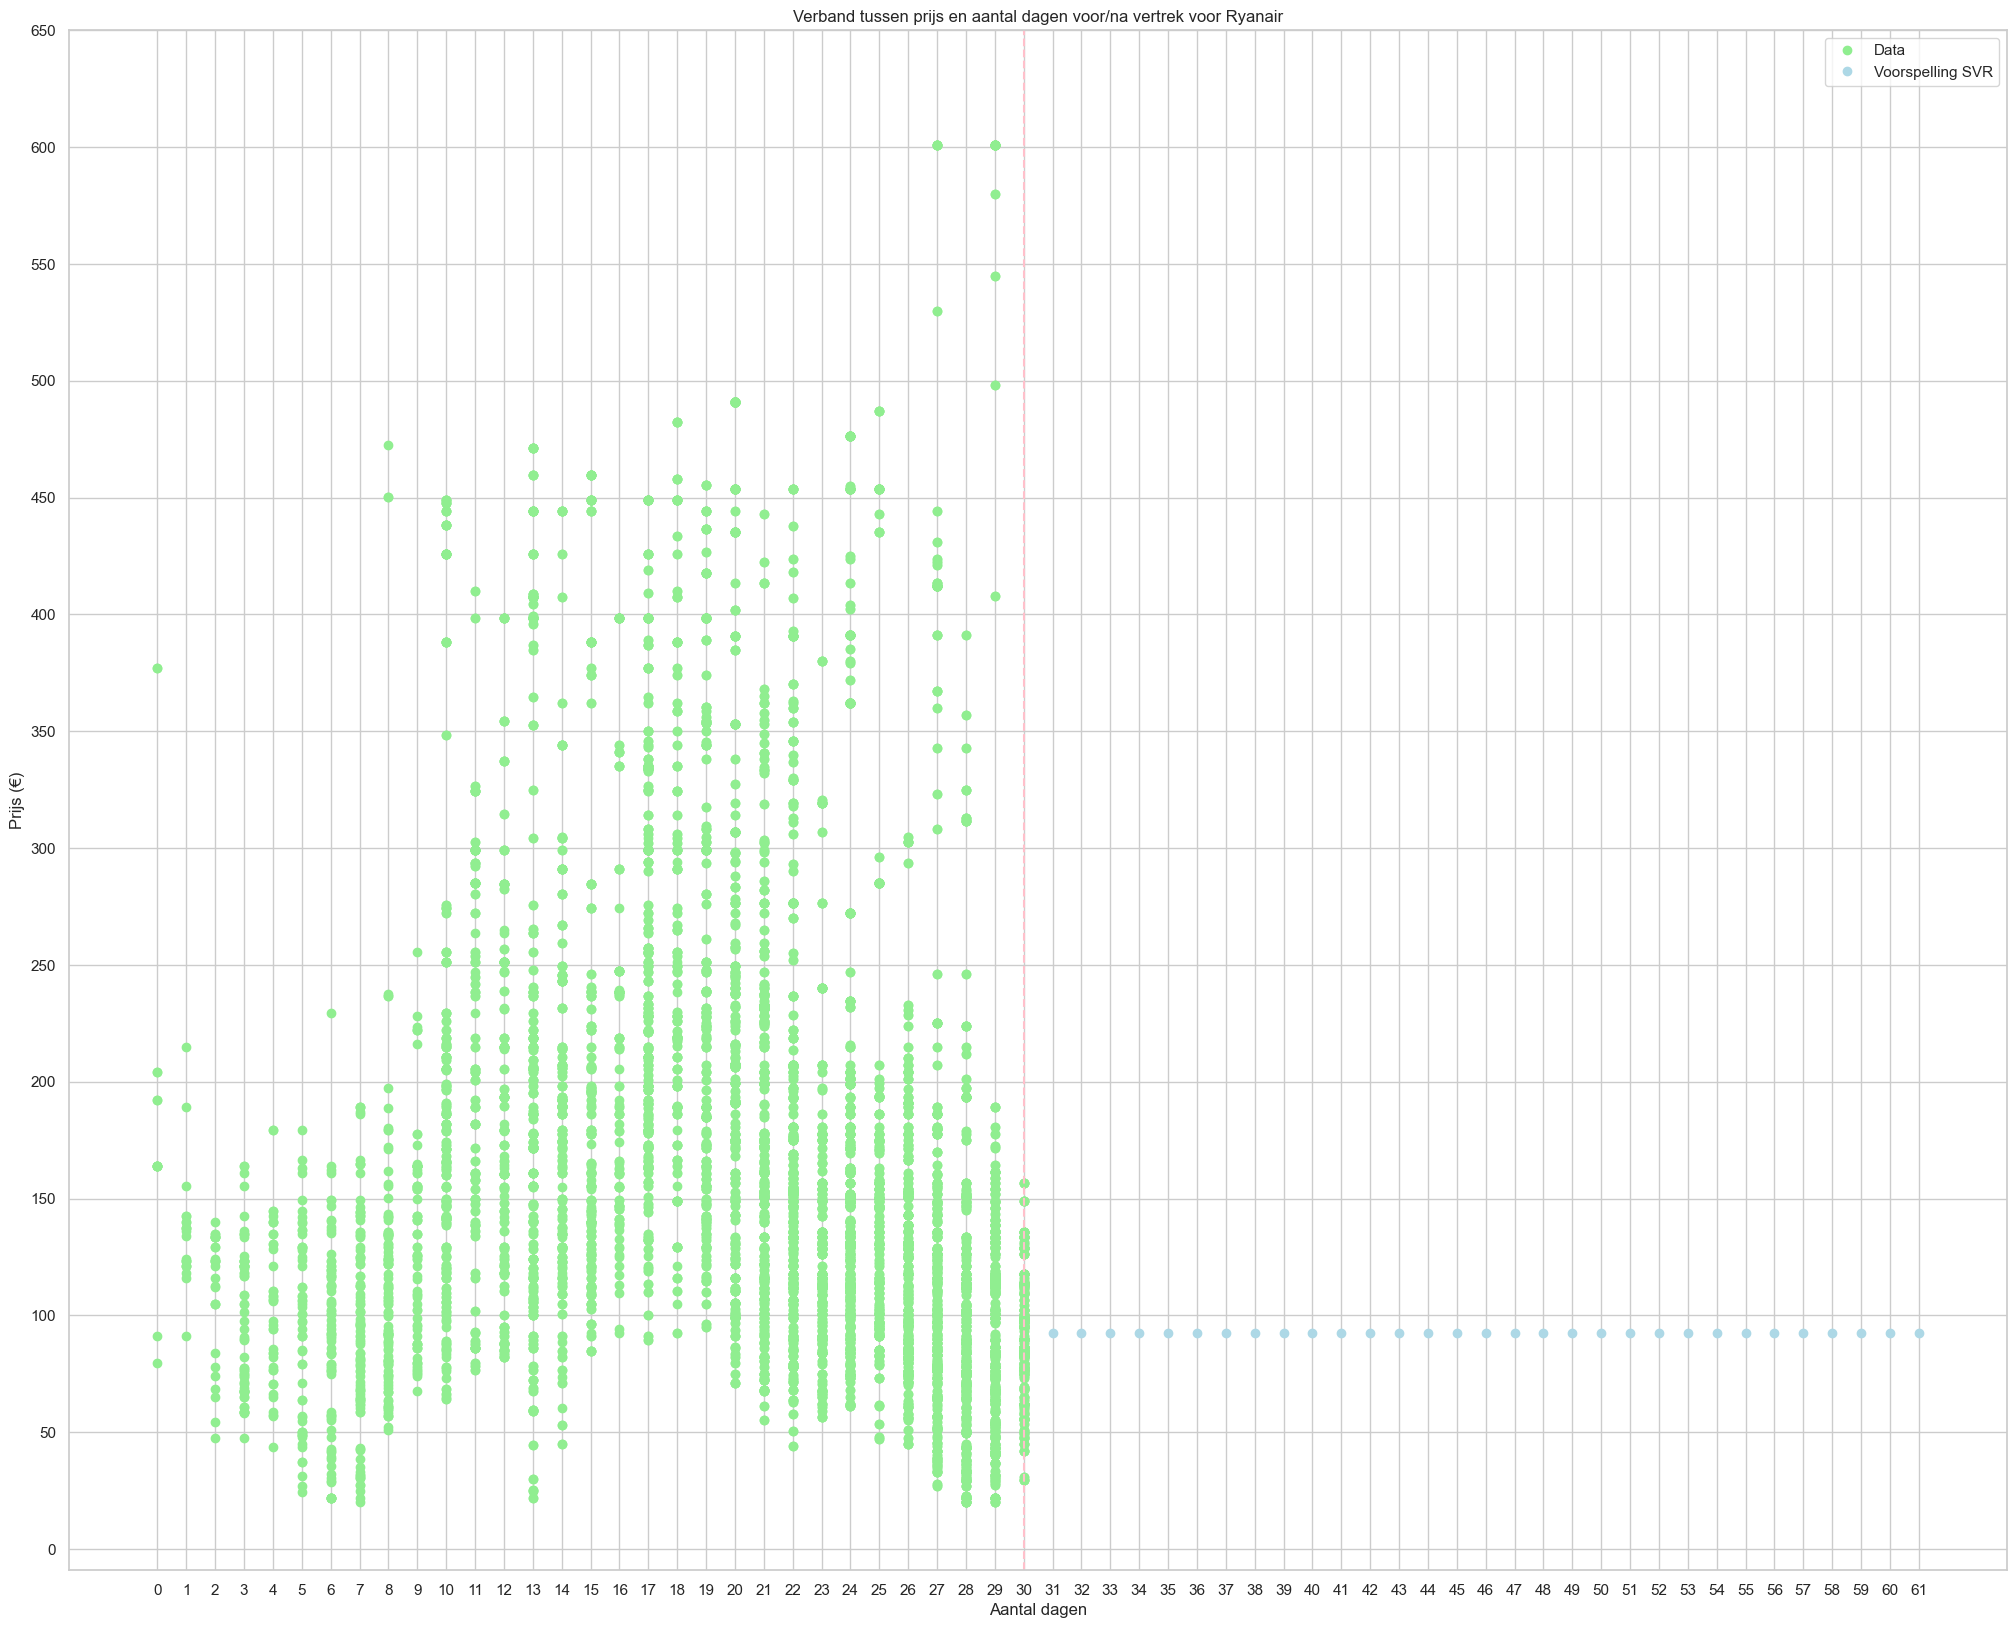

Accuracy score: 25.067709077022204 %
MSE: 7724.208946190313
Best parameters: {'max_depth': 4}
DecisionTreeRegressor(max_depth=4)
0.19024595428103427


In [49]:
# read data for Ryanair only
from sklearn.model_selection import GridSearchCV


data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create grid search model for decision tree regressor
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
dt = DecisionTreeRegressor()
clf = GridSearchCV(dt, parameters)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
clf.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_svr = clf.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_svr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling SVR'])
plt.show()

# print the accuracy score and mse + best parameters
print(f"Accuracy score: {clf.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, clf.predict(X_train))}")
print(f"Best parameters: {clf.best_params_}")
print(clf.best_estimator_)
print(clf.best_score_)

De x-as van deze grafieken moet je interpreteren als volgt: 
- Van 0 tot en met 30 zijn de waarden voor de dagen voor vertrek (30 = 0 dagen voor vertrek, dus vandaag ; 0 = 30 dagen geleden)
- Van 31 tot en met 61 zijn de dagen van de komende maand (31 = morgen, 61 = volgende maand)

Samenvattend moet je kijken naar de verticale lijn, dit is het 'midden': alles ervoor zijn het aantal dagen voor vertrek, alles erna zijn de komende dagen (hoe dichter bij de lijn, hoe korter bij het heden; hie verder weg, hoe verder in het verleden of de toekomst)

### 15) In PowerBI een kaart maken met de mogelijke bestemmingen als de prijs in een bepaalde range moet liggen (op een bepaald moment).

In PowerBI

Is volledig opgelost, blad noemt "15"